# Clustering towns and public housing blocks in Singapore

Submitted for IT 5100F Industry Readiness: Data analytics and AI in practice

By:
|Name|Student number|NUSNET ID|
|---|---|---|
|Wen Shu|A0286171B|e1237233|
|Shamik Banerjee|A0276524Y|e1132257|
|Marco G. A. Stopper|A0280071N|e1143884|
|Seah Ee Wei|A0276567L|e1132300|

## 1. Defining the problem

While Singapore is a small city, systematic urban planning by the government has meant that our lives have developed around the towns we live in. Most of us grew up in one town and are likely to stay in that town. Even when young adults look to buy new apartments, they are given subsidies to live near their parents (i.e., their childhood home).

In this project, we want to explore the concept of the town and how different or similar they are. Are there old or new towns? Do older or younger people live in those towns? Are towns that are next to each other more similar to each other? We also want to apply this inquiry to public housing blocks. Are there blocks with similar characteristics?

Our objectives for this data pipeline are:

* To identify public housing clusters on two levels: clustering **towns**, and clustering **public housing blocks**.

* To gain insights and analysis through visualising trends in each town, but also trends in the clusters obtained through unsupervised learning, in the hope that we learn something new.

The success of our data pipeline is measured by whether we are able to observe interesting and useful trends in the data and from our model, and whether it matches the literature and our own experiences.

On the technical front, as we are using clustering algorithms, we will measure the success of our model by traditional metrics such as silhouette scores and inertia.

Finally, we envision two main use cases for our data pipeline:
* For an interested user to explore the data and visualisations to learn more about the towns and their trends in Singapore.
* For users who are looking to move but still want similar amenities and demographics to their current town/block, to find similar towns and public housing blocks that they can consider in their search.

## 2. Collecting and curating the data

### Datasets for town clustering

For the town clustering, we are interested in data relating to the demographics and physical characteristics of each town. We are also interested in the median resales prices of each town, although that is only one factor that could potentially indicate affluent the town is. What we are less interested in is location data of each town, such as its longitude and latitude or whether it is located in the north/south etc. This is because our aim is to group towns not by their location but their other characteristics.

Having looked at the potential datasets from HDB, we selected these:
* HDB Property Information - contains data on how old each flat in each town is, whether there is a market in each block, the number of flats and types in each block, etc.
* Age of HDB Resident Population by Geographical Distribution - the percentage of residents who are in defined age brackets in each town
* HDB Resident Population by Geographical Distribution - the number of residents living in public housing in each town
* HDB Elderly and Future Elderly Resident Population by Geographical Distribution - another indicator of whether there is an ageing demographic in particular towns
* Median Resale Prices by Town and Flat Type - to indicate the potential affluence or popularity of a town.

### Datasets for block clustering

The HDB Property Information dataset is also relevant and forms the building block for our block clustering. But we have also added a list of datasets for clustering of public housing amentities, such as spatial information of nearby amenities such as distances to nearest mrts, upcoming mrts, schools and malls, which generally is the best deciding factor when clustering by blocks.

Having looked at the potential datasets from publicly available sites such as Kaggle, we went ahead with the following few:

* SG ZipCode Mapper - which basically consists of latitude and longitude details of each block. We will not be using this for our clustering purposes as we do not want to bias it towards location, but will be calculating distances to nearby amenities such as nearby mrt's, upcoming mrt's, schools, malls.
* SG Mrt Existing Stations - provides the latitude and longitude details of each nearby station, whose distance we will be incorporating later as a feature for the block clustering process.
* SG Mrt Planned stations - provides the latitude and longitude details of each upcoming station, whose distance we will be incorporating later as a feature for the block clustering process.
* SG Primary Schools - provides the latitude and longitude details each primary school, whose distance we will be incorporating later as a feature for the block clustering process.
* SG Shopping Malls - provides the latitude and longitude details of each shopping malls, whose distance we will be incorporating later as a feature for the block clustering process.


The main limitation with most of these datasets is that they only cover 2013 to 2018, which are the two most recent HDB surveys. The 2023/24 results are not currently available to us.

We therefore decided to use data points only from 2018, where possible, for these reasons.

First, using only data points from 2018 ensures consistency across the time element of the data points.

Second, as towns have been developing since 1952 (Queenstown), the character of each town is likely to evolve gradually, making insights from 2018 potentially still relevant today.

Third, if our clustering approach shows interesting trends, we can apply these insights to updated data when the latest results are out.

## 3. Part 1 - Towns Clustering - Data Preparation

In [1]:
# import the necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path = "original_hdb_data/"

# import our identified datasets
hdbs = pd.read_csv(path + 'HDBPropertyInformation.csv')
residents_by_age = pd.read_csv(path + 'AgeofHDBResidentPopulationbyGeographicalDistribution.csv')
residents_by_population = pd.read_csv(path + 'HDBResidentPopulationbyGeographicalDistribution.csv')
number_of_hdbs = pd.read_csv(path + 'DwellingUnitsunderHDBsManagementbyTownandFlatType.csv')
elderly_populations = pd.read_csv(path + 'HDBElderlyandFutureElderlyResidentPopulationbyGeographicalDistribution.csv')
median_resale_prices = pd.read_csv(path + 'MedianResalePricesforRegisteredApplicationsbyTownandFlatType.csv')

The HDB property information is most relevant, and we will start there.

In [3]:
# Check for nan values - there are none.
print(hdbs.isnull().sum())

blk_no                   0
street                   0
max_floor_lvl            0
year_completed           0
residential              0
commercial               0
market_hawker            0
miscellaneous            0
multistorey_carpark      0
precinct_pavilion        0
bldg_contract_town       0
total_dwelling_units     0
1room_sold               0
2room_sold               0
3room_sold               0
4room_sold               0
5room_sold               0
exec_sold                0
multigen_sold            0
studio_apartment_sold    0
1room_rental             0
2room_rental             0
3room_rental             0
other_room_rental        0
dtype: int64


In [4]:
# Check for duplicated values - there are none
print(hdbs.duplicated().sum())

0


In [5]:
# Check columns and types for the dataset
print(hdbs.dtypes)

blk_no                   object
street                   object
max_floor_lvl             int64
year_completed            int64
residential              object
commercial               object
market_hawker            object
miscellaneous            object
multistorey_carpark      object
precinct_pavilion        object
bldg_contract_town       object
total_dwelling_units      int64
1room_sold                int64
2room_sold                int64
3room_sold                int64
4room_sold                int64
5room_sold                int64
exec_sold                 int64
multigen_sold             int64
studio_apartment_sold     int64
1room_rental              int64
2room_rental              int64
3room_rental              int64
other_room_rental         int64
dtype: object


In [6]:
# We can see that the residential, commercial etc. columns have Y / N values.
hdbs.head(10)

,blk_no,street,max_floor_lvl,year_completed,residential,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,...,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental
0,1,BEACH RD,16,1970,Y,Y,N,N,N,N,...,138,1,2,0,0,0,0,0,0,0
1,1,BEDOK STH AVE 1,14,1975,Y,N,N,Y,N,N,...,204,0,2,0,0,0,0,0,0,0
2,1,CANTONMENT RD,2,2010,N,Y,N,N,N,N,...,0,0,0,0,0,0,0,0,0,0
3,1,CHAI CHEE RD,15,1982,Y,N,N,N,N,N,...,0,10,92,0,0,0,0,0,0,0
4,1,CHANGI VILLAGE RD,4,1975,Y,Y,N,N,N,N,...,54,0,1,0,0,0,0,0,0,0
5,1,DELTA AVE,25,1982,Y,N,N,N,N,N,...,0,0,96,0,0,0,0,0,0,0
6,1,DOVER RD,12,1975,Y,N,N,Y,N,N,...,118,0,7,0,0,0,0,0,0,0
7,1,EUNOS CRES,14,1977,Y,N,N,Y,N,N,...,0,0,0,0,0,0,0,247,0,0
8,1,EVERTON PK,12,1980,Y,Y,N,N,N,N,...,62,0,33,0,0,0,0,0,0,0
9,1,GEYLANG SERAI,2,2009,N,Y,N,N,N,N,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# We will convert these to 1 / 0 values for easier analysis

cols = ['residential', 'commercial', 'market_hawker', 'miscellaneous', 'multistorey_carpark', 'precinct_pavilion']

for col in cols:
    hdbs[col] = hdbs[col].map({'Y': 1, 'N': 0})

In [8]:
# We can also see that the town values are not easy to read.
hdbs['bldg_contract_town'].unique()

array(['KWN', 'BD', 'CT', 'PRC', 'BM', 'QT', 'GL', 'HG', 'TP', 'SGN',
       'MP', 'WL', 'PG', 'BT', 'TAP', 'CCK', 'AMK', 'BH', 'BB', 'SB',
       'CL', 'BP', 'JE', 'SK', 'YS', 'JW', 'TG'], dtype=object)

In [9]:
# We will map them to a more readable format, and also rename the column to 'town'

towns = {
    'AMK': 'ANG MO KIO',
    'BB': 'BUKIT BATOK',
    'BD': 'BEDOK',
    'BH': 'BISHAN',
    'BM': 'BUKIT MERAH',
    'BP': 'BUKIT PANJANG',
    'BT': 'BUKIT TIMAH',
    'CCK': 'CHOA CHU KANG',
    'CL': 'CLEMENTI',
    'CT': 'CENTRAL AREA',
    'GL': 'GEYLANG',
    'HG': 'HOUGANG',
    'JE': 'JURONG EAST',
    'JW': 'JURONG WEST',
    'KWN': 'KALLANG/WHAMPOA',
    'MP': 'MARINE PARADE',
    'PG': 'PUNGGOL',
    'PRC': 'PASIR RIS',
    'QT': 'QUEENSTOWN',
    'SB': 'SEMBAWANG',
    'SGN': 'SERANGOON',
    'SK': 'SENGKANG',
    'TAP': 'TAMPINES',
    'TG': 'TENGAH',
    'TP': 'TOA PAYOH',
    'WL': 'WOODLANDS',
    'YS': 'YISHUN'
}

hdbs['bldg_contract_town'] = hdbs['bldg_contract_town'].map(towns)

hdbs = hdbs.rename(columns={'bldg_contract_town': 'town'})

In [10]:
# Values look good!
hdbs.head()

,blk_no,street,max_floor_lvl,year_completed,residential,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,...,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental
0,1,BEACH RD,16,1970,1,1,0,0,0,0,...,138,1,2,0,0,0,0,0,0,0
1,1,BEDOK STH AVE 1,14,1975,1,0,0,1,0,0,...,204,0,2,0,0,0,0,0,0,0
2,1,CANTONMENT RD,2,2010,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,CHAI CHEE RD,15,1982,1,0,0,0,0,0,...,0,10,92,0,0,0,0,0,0,0
4,1,CHANGI VILLAGE RD,4,1975,1,1,0,0,0,0,...,54,0,1,0,0,0,0,0,0,0


In [11]:
# Since this part of the analysis is for towns, we will aggregate the data by town
# Approach: For the max_floor_level and year_completed, we will take the mean value, and for the rest, we will take the sum since they refer to each building in a town.

hdbs = hdbs.groupby('town').agg({
    'max_floor_lvl': 'mean',
    'year_completed': 'mean',
    'residential': 'sum',
    'commercial': 'sum',
    'market_hawker': 'sum',
    'miscellaneous': 'sum',
    'multistorey_carpark': 'sum',
    'precinct_pavilion': 'sum',
    'total_dwelling_units': 'sum',
    '1room_sold': 'sum',
    '2room_sold': 'sum',
    '3room_sold': 'sum',
    '4room_sold': 'sum',
    '5room_sold': 'sum',
    'exec_sold': 'sum',
    'multigen_sold': 'sum',
    'studio_apartment_sold': 'sum',
    '1room_rental': 'sum',
    '2room_rental': 'sum',
    '3room_rental': 'sum',
    'other_room_rental': 'sum'}).reset_index()

In [12]:
# This is looking pretty good.
hdbs.head()

,town,max_floor_lvl,year_completed,residential,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,total_dwelling_units,...,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental
0,ANG MO KIO,11.838137,1984.190687,387,127,10,130,20,16,51309,...,24440,14703,6150,503,0,302,1314,2855,73,12
1,BEDOK,11.573693,1987.876387,530,160,9,153,36,26,64415,...,23000,21971,10773,2718,0,263,2604,1551,15,0
2,BISHAN,11.773381,1988.899281,230,100,2,57,19,4,19676,...,2352,9359,5716,1567,93,147,168,240,5,0
3,BUKIT BATOK,11.695568,1995.077071,434,116,1,130,35,29,46982,...,11985,18823,7964,2734,0,221,919,781,21,0
4,BUKIT MERAH,13.562610,1984.818342,429,155,14,120,52,45,54153,...,15782,17192,9622,47,0,548,4412,4601,185,1


### Adding other datasets

In [13]:
# Let's add the other datasets to this one.
# They tend to follow a similar data structure like this:

residents_by_age.head()

,shs_year,town_estate,age_group,percentage
0,2013,Sengkang,Below 15,24.0
1,2013,Sengkang,15 - 24,11.6
2,2013,Sengkang,25 - 34,13.4
3,2013,Sengkang,35 - 44,19.6
4,2013,Sengkang,45 - 54,16.4


In [14]:
# We will restructure them to only include the most recent year (2018), with the town as a row, each age group as a column, and the percentage of residents in that age group as the value.

residents_by_age = residents_by_age[residents_by_age['shs_year'] == 2018]
residents_by_age = residents_by_age.pivot(index='town_estate', columns='age_group', values='percentage').reset_index()

# Rename the town_estate column to town
residents_by_age = residents_by_age.rename(columns={'town_estate': 'town'})

residents_by_age.head()

age_group,town,15 - 24,25 - 34,35 - 44,45 - 54,55 - 64,65 & Above,Below 15
0,Ang Mo Kio,9.7,10.3,12.5,13.6,17.9,24.6,11.4
1,Bedok,13.6,13.6,9.0,13.9,18.5,21.8,9.6
2,Bishan,13.3,10.0,12.9,14.2,19.9,19.9,9.8
3,Bukit Batok,13.5,11.3,11.5,16.3,18.1,17.2,12.1
4,Bukit Merah,9.0,9.6,12.8,14.1,16.6,25.7,12.2


In [15]:
# do the same for residents_by_population, elderly_populations, median_resale_prices

residents_by_population = residents_by_population[residents_by_population['shs_year'] == 2018]
residents_by_population = residents_by_population.pivot(index='town_estate', columns='shs_year', values='number').reset_index()
residents_by_population.columns = ['town', 'number']

residents_by_population.head()

,town,number
0,Ang Mo Kio,126300
1,Bedok,174900
2,Bishan,55600
3,Bukit Batok,107200
4,Bukit Merah,134700


In [16]:
elderly_populations.head()

,shs_year,elderly_pop,town_estate,number
0,2003,Elderly,Sengkang,6398
1,2003,Elderly,Punggol,1387
2,2003,Elderly,Sembawang,2262
3,2003,Elderly,Jurong West,11885
4,2003,Elderly,Tampines,12200


In [17]:
elderly_populations = elderly_populations[elderly_populations['shs_year'] == 2018]

# There are duplicate entries for Hougang, so we will take the mean of the two values.
elderly_populations = elderly_populations.groupby(['town_estate', 'elderly_pop']).agg({'number': 'mean'}).reset_index()
elderly_populations = elderly_populations.pivot(index='town_estate', columns='elderly_pop', values='number').reset_index()

# Rename town_estate to town
elderly_populations = elderly_populations.rename(columns={'town_estate': 'town'})

elderly_populations.head()

elderly_pop,town,Elderly,Future Elderly
0,Ang Mo Kio,31000.0,22600.0
1,Bedok,38200.0,32300.0
2,Bishan,10400.0,18800.0
3,Bukit Batok,14900.0,11400.0
4,Bukit Merah,34700.0,22500.0


In [18]:
median_resale_prices.head()

,quarter,town,flat_type,price
0,2007-Q2,Ang Mo Kio,1-room,na
1,2007-Q2,Ang Mo Kio,2-room,-
2,2007-Q2,Ang Mo Kio,3-room,172000
3,2007-Q2,Ang Mo Kio,4-room,260000
4,2007-Q2,Ang Mo Kio,5-room,372000


In [27]:
# Replace non-numeric 'price' values with nan
median_resale_prices['price'].replace(['na', '-'], np.nan, inplace=True)
median_resale_prices['price'] = pd.to_numeric(median_resale_prices['price'], errors='coerce')

# Extract the year from the 'quarter' and create a new 'year' column
median_resale_prices['year'] = median_resale_prices['quarter'].apply(lambda x: int(x.split('-')[0]))

# Filter data for the year 2018
data_2018 = median_resale_prices[median_resale_prices['year'] == 2018]

# Group by town and flat_type, then calculate the mean price across quarters
mean_prices_2018 = data_2018.groupby(['town', 'flat_type']).agg({'price': 'mean'}).reset_index()

# For completely missing 2018 data, look at data from 2015 to 2021
years = [2015, 2016, 2017, 2019, 2020, 2021]
data_2015_2017 = median_resale_prices[median_resale_prices['year'].isin(years)]
mean_prices_2015_2017 = data_2015_2017.groupby(['town', 'flat_type']).agg({'price': 'mean'}).reset_index()
filled_prices_2018 = pd.merge(mean_prices_2018, mean_prices_2015_2017, on=['town', 'flat_type'], how='left', suffixes=('', '_15_17'))
filled_prices_2018['price'] = filled_prices_2018['price'].fillna(filled_prices_2018['price_15_17'])
final_prices_2018 = filled_prices_2018.drop(columns=['price_15_17'])

# There are still 73 nan values.
print(len(final_prices_2018[final_prices_2018['price'].isnull()]))

# Reorganise the data to have flat_type as columns
final_prices_2018 = final_prices_2018.pivot(index='town', columns='flat_type', values='price').reset_index()

# Remove 1 and 2 room flats as they are not available for resale
final_prices_2018 = final_prices_2018.drop(columns=['1-room', '2-room'])

# Fill in nan rows with the mean
fill_values = {
    '3-room': final_prices_2018['3-room'].mean(),
    '4-room': final_prices_2018['4-room'].mean(),
    '5-room': final_prices_2018['5-room'].mean(),
    'Executive': final_prices_2018['Executive'].mean()
}
final_prices_2018.fillna(value=fill_values, inplace=True)
# final_prices_2018 = final_prices_2018.fillna(final_prices_2018.mean())

final_prices_2018

73


/var/folders/yz/mzhr49gj08xbk2y3x6ctv23w0000gn/T/ipykernel_88703/486688266.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  median_resale_prices['price'].replace(['na', '-'], np.nan, inplace=True)


flat_type,town,3-room,4-room,5-room,Executive
0,Ang Mo Kio,287100.000000,443000.0,698075.000000,599152.380952
1,Bedok,290500.000000,406250.0,584575.000000,724000.000000
2,Bishan,305292.424242,554625.0,752875.000000,599152.380952
3,Bukit Batok,262000.000000,378350.0,521500.000000,611750.000000
4,Bukit Merah,338375.000000,663125.0,778700.000000,599152.380952
5,Bukit Panjang,278000.000000,364625.0,468250.000000,593333.333333
6,Bukit Timah,305292.424242,466875.0,562773.188406,599152.380952
7,Central,404000.000000,860000.0,562773.188406,599152.380952
8,Choa Chu Kang,268000.000000,334375.0,396000.000000,534375.000000
9,Clementi,315350.000000,575375.0,635500.000000,599152.380952


### Merging the datasets

In [28]:
# We will now merge the additional datasets together, but first we will check that the town names are consistent across all datasets.

print(hdbs['town'].unique())
print(residents_by_age['town'].unique())
print(residents_by_population['town'].unique())
print(elderly_populations['town'].unique())
print(final_prices_2018['town'].unique())

# Replace final_prices_2018 'Central' with 'Central Area'
final_prices_2018['town'] = final_prices_2018['town'].replace('Central', 'Central Area')

# Replace 'Kallang Whampoa' with 'Kallang/Whampoa' and 'Jurong_west' with 'Jurong West' in residents by population
residents_by_population['town'] = residents_by_population['town'].replace('Kallang Whampoa', 'Kallang/Whampoa')

# Replace hdb town names with .title()
hdbs['town'] = hdbs['town'].apply(lambda x: x.title())

# Tengah is a new town and does not have most of the demographic data as of 2018. Thus, we will drop it from the hdb dataset.
hdbs = hdbs[hdbs['town'] != 'Tengah']

['ANG MO KIO' 'BEDOK' 'BISHAN' 'BUKIT BATOK' 'BUKIT MERAH' 'BUKIT PANJANG'
 'BUKIT TIMAH' 'CENTRAL AREA' 'CHOA CHU KANG' 'CLEMENTI' 'GEYLANG'
 'HOUGANG' 'JURONG EAST' 'JURONG WEST' 'KALLANG/WHAMPOA' 'MARINE PARADE'
 'PASIR RIS' 'PUNGGOL' 'QUEENSTOWN' 'SEMBAWANG' 'SENGKANG' 'SERANGOON'
 'TAMPINES' 'TENGAH' 'TOA PAYOH' 'WOODLANDS' 'YISHUN']
['Ang Mo Kio' 'Bedok' 'Bishan' 'Bukit Batok' 'Bukit Merah' 'Bukit Panjang'
 'Bukit Timah' 'Central Area' 'Choa Chu Kang' 'Clementi' 'Geylang'
 'Hougang' 'Jurong East' 'Jurong West' 'Kallang/Whampoa' 'Marine Parade'
 'Pasir Ris' 'Punggol' 'Queenstown' 'Sembawang' 'Sengkang' 'Serangoon'
 'Tampines' 'Toa Payoh' 'Woodlands' 'Yishun']
['Ang Mo Kio' 'Bedok' 'Bishan' 'Bukit Batok' 'Bukit Merah' 'Bukit Panjang'
 'Bukit Timah' 'Central Area' 'Choa Chu Kang' 'Clementi' 'Geylang'
 'Hougang' 'Jurong East' 'Jurong_west' 'Kallang Whampoa' 'Marine Parade'
 'Pasir Ris' 'Punggol' 'Queenstown' 'Sembawang' 'Sengkang' 'Serangoon'
 'Tampines' 'Toa Payoh' 'Woodlands' 'Yish

In [29]:
# Rename the columns in each dataset to be more descriptive

residents_by_age.columns

residents_by_age.columns = [
    'town',
    'age_group_15_24',
    'age_group_25_34',
    'age_group_35_44',
    'age_group_45_54',
    'age_group_55_64',
    'age_group_65+',
    'age_group_15_under',
]

residents_by_population.columns = ['town', 'population']

elderly_populations.columns = ['town', 'elderly_pop', 'future_elderly_pop']

final_prices_2018.columns = ['town', '3_room_median_price', '4_room_median_price', '5_room_median_price', 'exec_median_price']

In [30]:
# Merge all datasets together

data = hdbs.merge(residents_by_age, on='town', how='left')
data = data.merge(residents_by_population, on='town', how='left')
data = data.merge(elderly_populations, on='town', how='left')
data = data.merge(final_prices_2018, on='town', how='left')

data.columns

Index(['town', 'max_floor_lvl', 'year_completed', 'residential', 'commercial',
       'market_hawker', 'miscellaneous', 'multistorey_carpark',
       'precinct_pavilion', 'total_dwelling_units', '1room_sold', '2room_sold',
       '3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental',
       'other_room_rental', 'age_group_15_24', 'age_group_25_34',
       'age_group_35_44', 'age_group_45_54', 'age_group_55_64',
       'age_group_65+', 'age_group_15_under', 'population', 'elderly_pop',
       'future_elderly_pop', '3_room_median_price', '4_room_median_price',
       '5_room_median_price', 'exec_median_price'],
      dtype='object')

In [31]:
# Print rows with nan values
data[data.isnull().any(axis=1)]

# There are only a few more missing values, so we will fill them with the mean.
data = data.fillna(data.mean(numeric_only=True))

In [32]:
# Save the data to a new csv file for submission
data.to_csv('curated_data/part1_curated_data.csv', index=False)

# 4. Part 1 - Towns Clustering - Exploratory data analysis and visualisation

### Summary statistics

Let's look at some statistics ! We can see from an overview of the overall stats:
* The medan / median height of public housing blocks in each town is around 12 storeys high.
* There are an average of 4 markets / hawker centres in each town, but the maximum is 14 (Bukit Merah).
* The average age of public housing blocks in each town is around 31 years old (average year completed = 1993)

In [33]:
data.describe()

,max_floor_lvl,year_completed,residential,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,...,age_group_55_64,age_group_65+,age_group_15_under,population,elderly_pop,future_elderly_pop,3_room_median_price,4_room_median_price,5_room_median_price,exec_median_price
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,...,26.000000,26.000000,26.000000,26.000000,26.0000,26.000000,26.000000,26.00000,26.000000,26.000000
mean,12.370425,1992.218218,401.961538,96.346154,4.192308,113.884615,41.115385,32.038462,43523.192308,9.730769,...,16.203846,18.846154,13.346154,112516.000000,19198.0000,18108.000000,305292.424242,466875.00000,562773.188406,599152.380952
std,1.596225,7.567563,223.362930,48.945637,3.633392,59.096752,28.007609,26.542767,22332.245890,49.617382,...,2.610667,7.267529,3.765552,60511.722368,9645.4806,9933.616461,39069.765300,129901.68032,135179.069323,51797.458348
min,10.361147,1978.358974,27.000000,6.000000,0.000000,11.000000,3.000000,0.000000,2554.000000,0.000000,...,8.700000,5.900000,9.200000,7600.000000,1700.0000,1500.000000,249500.000000,327700.00000,385225.000000,473500.000000
25%,11.049536,1987.837695,234.500000,61.250000,1.250000,72.500000,19.250000,13.750000,29667.750000,0.000000,...,15.825000,13.575000,11.400000,71500.000000,11500.0000,11400.000000,278437.500000,379262.50000,458931.250000,588208.333333
50%,11.915636,1991.153915,372.000000,98.000000,3.000000,100.000000,36.000000,28.500000,42724.000000,0.000000,...,16.600000,20.450000,12.100000,108800.000000,18849.0000,17004.000000,304896.212121,434625.00000,535475.000000,599152.380952
75%,13.357363,1995.740009,540.500000,125.750000,6.750000,156.000000,52.000000,41.250000,60014.000000,0.000000,...,17.850000,24.600000,14.975000,157925.000000,24625.0000,22575.000000,326525.000000,528656.25000,630908.333333,599152.380952
max,16.801980,2011.214876,883.000000,186.000000,14.000000,222.000000,107.000000,110.000000,82465.000000,253.000000,...,20.000000,34.100000,25.300000,227600.000000,38200.0000,41000.000000,404000.000000,860000.00000,843500.000000,724000.000000


In [34]:
data.head()

,town,max_floor_lvl,year_completed,residential,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,total_dwelling_units,...,age_group_55_64,age_group_65+,age_group_15_under,population,elderly_pop,future_elderly_pop,3_room_median_price,4_room_median_price,5_room_median_price,exec_median_price
0,Ang Mo Kio,11.838137,1984.190687,387,127,10,130,20,16,51309,...,17.9,24.6,11.4,126300.0,31000.0,22600.0,287100.000000,443000.0,698075.0,599152.380952
1,Bedok,11.573693,1987.876387,530,160,9,153,36,26,64415,...,18.5,21.8,9.6,174900.0,38200.0,32300.0,290500.000000,406250.0,584575.0,724000.000000
2,Bishan,11.773381,1988.899281,230,100,2,57,19,4,19676,...,19.9,19.9,9.8,55600.0,10400.0,18800.0,305292.424242,554625.0,752875.0,599152.380952
3,Bukit Batok,11.695568,1995.077071,434,116,1,130,35,29,46982,...,18.1,17.2,12.1,107200.0,14900.0,11400.0,262000.000000,378350.0,521500.0,611750.000000
4,Bukit Merah,13.562610,1984.818342,429,155,14,120,52,45,54153,...,16.6,25.7,12.2,134700.0,34700.0,22500.0,338375.000000,663125.0,778700.0,599152.380952


### Interesting correlations and trends

We can also create a heatmap to visualise the correlation trends. While there are many values, we can observe some high correlations:

* There is a surprisingly almost perfect correlation (0.99) between the number of total dwelling units and the number of 'miscellaneous'. From the HDB property information dataset website, we know that 'miscellaneous' refers to facilities such as admin office, childcare centre, education centre, Residents' Committees centre (https://beta.data.gov.sg/datasets/d_17f5382f26140b1fdae0ba2ef6239d2f/view). This makes sense - the more the number of dwelling units, the more of such facilities there would be. However, the very high correlation may suggest that HDB has a dwelling to resident facilities ratio in place.

* The population is also positively correlated with the number of 4 room flats sold (0.93), meaning that as towns have more residents, the number of 4-room flats available also increase. While this may be obvious at first glance, it is important to note that the same strong correlation doesn't exist for 1, 2, and 3-room flats where there is only a low or moderate correlation (0.07 to 0.54). This suggests that the number of 1-3 room flats tends to remain constant, and population increase is serviced by building more 4 and 5 room flats.

* It is also interesting that the towns with more public commercial properties are strongly correlated with the elderly and future elderly population (0.85 and 0.86). This may suggest that the older towns (where the residents are now getting older) used to be more integrated with commercial facilities. An accompanying correlation would be the negative correlation between the average year completed (a proxy for the town's age) (-0.9) and the proportion of adults above 65. This means that as the town gets older, the proportion of elderly increases. On the other side of the coin, as the town gets younger, the proportion of those under 15 increases (0.82).

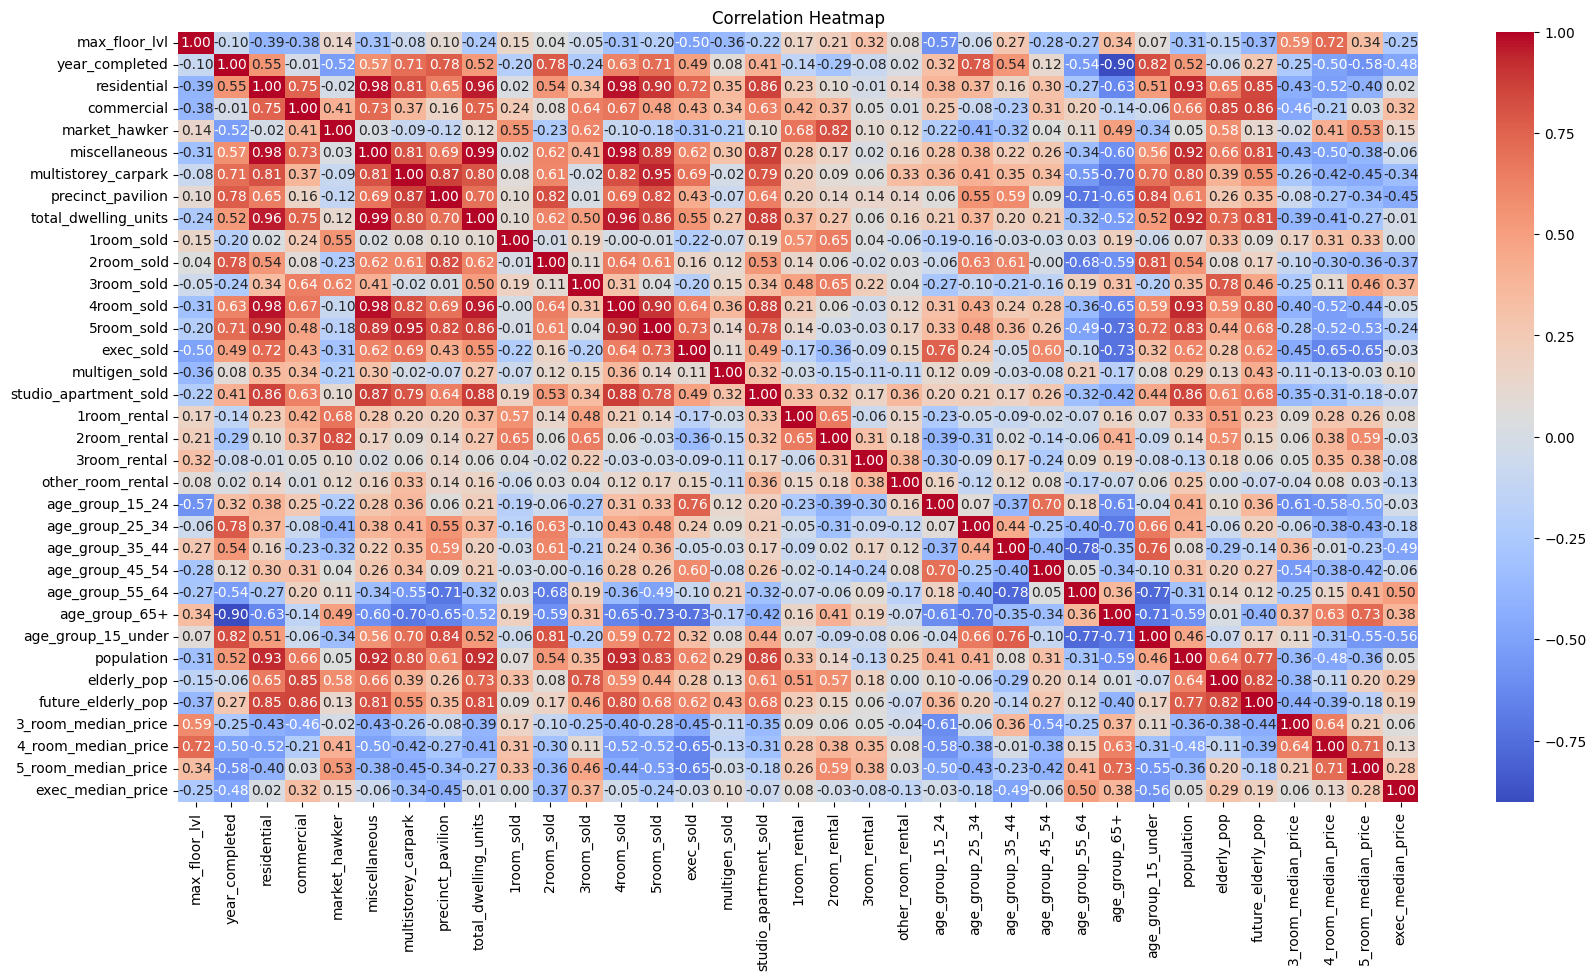

In [35]:
# Heatmap for correlation - see above for analysis
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### Demographics across towns - age of residents in each town

Let's look at some bar plots to visualise the demographic spread of the towns.

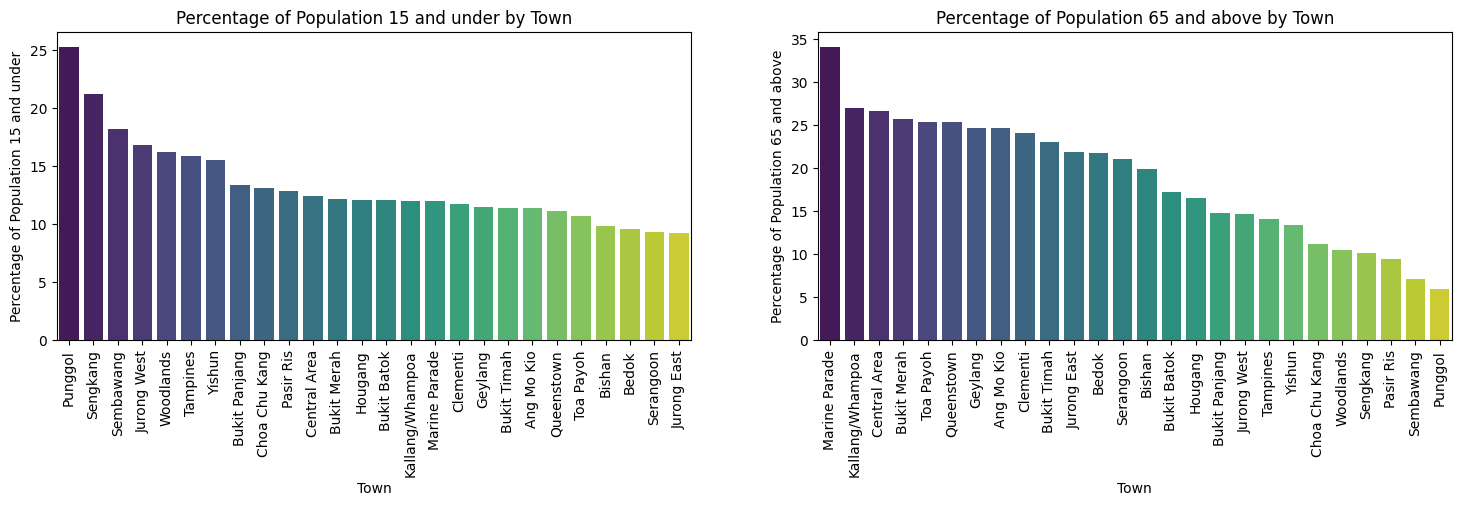

In [37]:
import warnings
warnings.filterwarnings("ignore", message="When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group")
# bar plot of kids under 15 per town

# 2 subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.barplot(x='town', y='age_group_15_under', data=data.sort_values('age_group_15_under', ascending=False), palette='viridis', hue='town', ax=ax[0])
ax[0].set_title('Percentage of Population 15 and under by Town')
ax[0].set_xlabel('Town')
ax[0].set_ylabel('Percentage of Population 15 and under')
ax[0].xaxis.set_ticks(np.arange(0, len(data['town'].unique()), 1))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

sns.barplot(x='town', y='age_group_65+', data=data.sort_values('age_group_65+', ascending=False), palette='viridis', hue='town', ax=ax[1])
ax[1].set_title('Percentage of Population 65 and above by Town')
ax[1].set_xlabel('Town')
ax[1].set_ylabel('Percentage of Population 65 and above')
ax[1].xaxis.set_ticks(np.arange(0, len(data['town'].unique()), 1))
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

plt.show()


From the plots above, the top three towns with percentage of population 15 and under are Punggol, Sengkang, and Sembawang, which are newer towns located in the north and northeast of Singapore. These three towns also constitute three out of the four towns with the lowest percentage of elderly (seen in the chart on the right), supporting our correlation observations above.

The towns with the highest percentage of elderly are Marine Parade, Kallang/Whampoa, and Central Area, which are located in the central / east of Singapore. They however maintain a decent proportion of children under 15, hovering at around 12%.

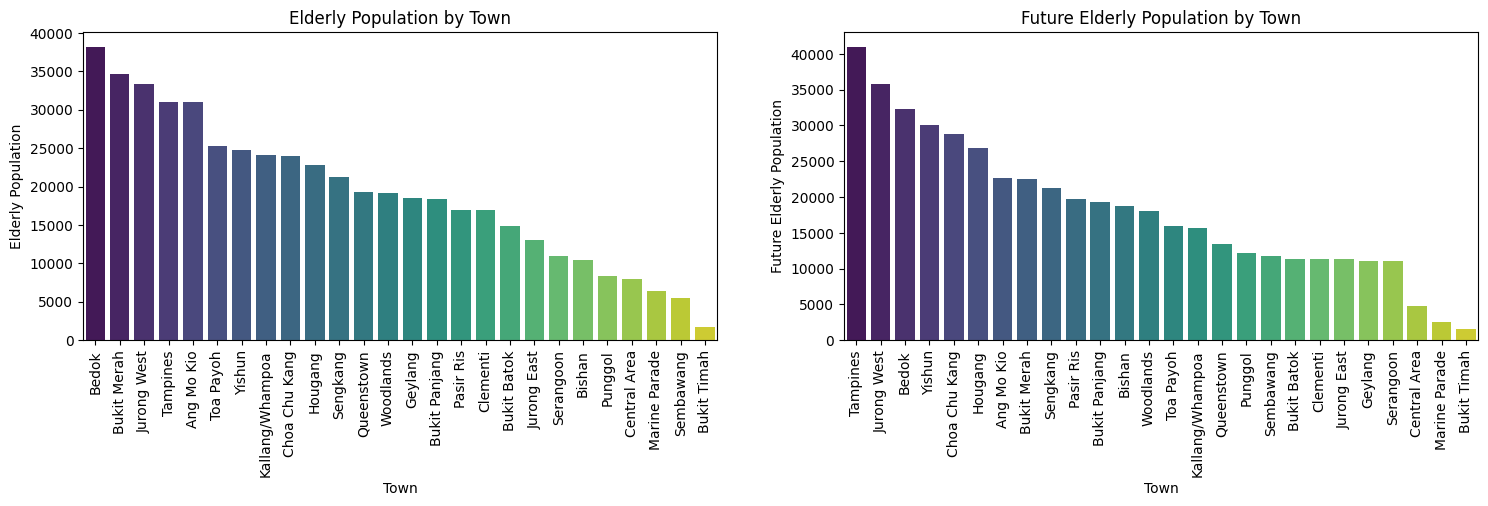

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.barplot(x='town', y='elderly_pop', data=data.sort_values('elderly_pop', ascending=False), palette='viridis', hue='town', ax=ax[0])
ax[0].set_title('Elderly Population by Town')
ax[0].set_xlabel('Town')
ax[0].set_ylabel('Elderly Population')
ax[0].xaxis.set_ticks(np.arange(0, len(data['town'].unique()), 1))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

sns.barplot(x='town', y='future_elderly_pop', data=data.sort_values('future_elderly_pop', ascending=False), palette='viridis', hue='town', ax=ax[1])
ax[1].set_title('Future Elderly Population by Town')
ax[1].set_xlabel('Town')
ax[1].set_ylabel('Future Elderly Population')
ax[1].xaxis.set_ticks(np.arange(0, len(data['town'].unique()), 1))
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

plt.show()

We can take a closer look at the elderly and future elderly populations in absolute numbers. It is worth noting that since this is by absolute number, towns with larger populations would also tend to have larger numbers of elderly and future elderly. It is thus not surprising that the order of towns is fairly similar across both charts. However, there are still some interesting things to note. For example, there is a significantly higher number of elderly in Kallang / Whampoa (between 20 to 25k) as compared to future elderly (between 15 to 20k), whereas the opposite is true in Tampines. This is useful in indicating the future demographic trends in each town.

### Town population and total dwelling units

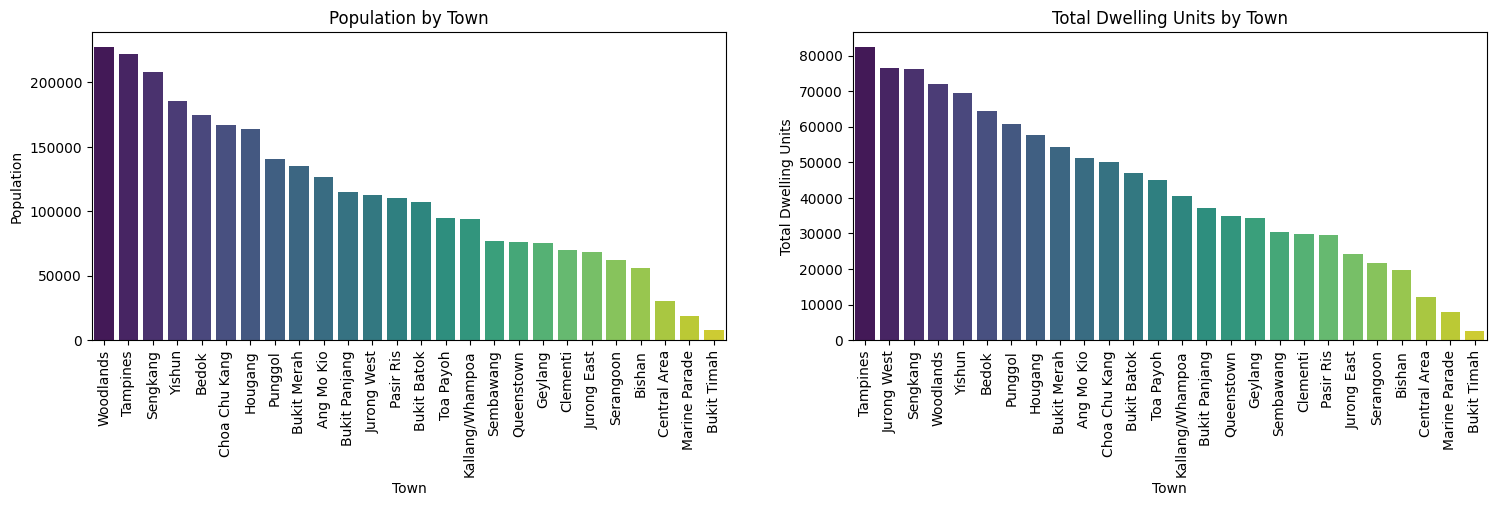

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.barplot(x='town', y='population', data=data.sort_values('population', ascending=False), palette='viridis', hue='town', ax=ax[0])
ax[0].set_title('Population by Town')
ax[0].set_xlabel('Town')
ax[0].set_ylabel('Population')
ax[0].xaxis.set_ticks(np.arange(0, len(data['town'].unique()), 1))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

sns.barplot(x='town', y='total_dwelling_units', data=data.sort_values('total_dwelling_units', ascending=False), palette='viridis', hue='town', ax=ax[1])
ax[1].set_title('Total Dwelling Units by Town')
ax[1].set_xlabel('Town')
ax[1].set_ylabel('Total Dwelling Units')
ax[1].xaxis.set_ticks(np.arange(0, len(data['town'].unique()), 1))
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

plt.show()

Finally, we can have a brief look at the size of each town in terms of population and total dwelling units. We can see that the largest towns are those located in the outer areas of Singapore, such as Woodlands (north), Jurong West (west), Sengkang (northeast) and Yishun (north).

### Units for rent vs units for sale

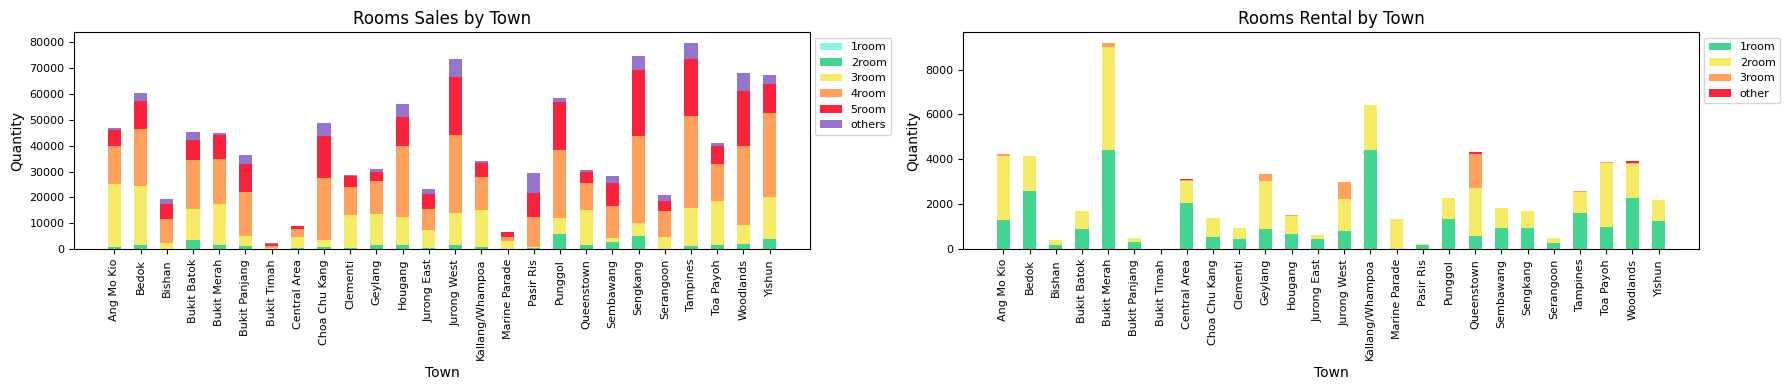

In [40]:
x = data['town']

bar_width = 0.5

fig, ax = plt.subplots(1, 2, figsize=(18, 4))

room1 = data['1room_sold']
room2 = data['2room_sold']
room3 = data['3room_sold']
room4 = data['4room_sold']
room5 = data['5room_sold']
others = data['exec_sold'] + data['multigen_sold'] + data['studio_apartment_sold']
colors = ['#88F7E2', '#44D492', '#F5EB67', '#FFA15C', '#FA233E', '#9575CD']

ax[0].bar(x, room1, width=bar_width, label='1room',color=colors[0])
ax[0].bar(x, room2, width=bar_width, bottom=room1, label='2room',color=colors[1])
ax[0].bar(x, room3, width=bar_width, bottom=room1+room2, label='3room',color=colors[2])
ax[0].bar(x, room4, width=bar_width, bottom=room1+room2+room3, label='4room',color=colors[3])
ax[0].bar(x, room5, width=bar_width, bottom=room1+room2+room3+room4, label='5room',color=colors[4])
ax[0].bar(x, others, width=bar_width, bottom=room1+room2+room3+room4+room5, label='others',color=colors[5])

ax[0].set_xticks(range(len(x)))
ax[0].set_xticklabels(x, rotation=90)
ax[0].set_xlabel('Town')
ax[0].set_ylabel('Quantity')
ax[0].set_title('Rooms Sales by Town')

ax[0].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), prop={'size': 8})
ax[0].tick_params(axis='x', labelsize=8)
ax[0].tick_params(axis='y', labelsize=8)

rroom1 = data['1room_rental']
rroom2 = data['2room_rental']
rroom3 = data['3room_rental']
other = data['other_room_rental']
colors = ['#88F7E2', '#44D492', '#F5EB67', '#FFA15C', '#FA233E', '#9575CD']

ax[1].bar(x, rroom1, width=bar_width, label='1room',color=colors[1])
ax[1].bar(x, rroom2, width=bar_width, bottom=rroom1, label='2room',color=colors[2])
ax[1].bar(x, rroom3, width=bar_width, bottom=rroom1+rroom2, label='3room',color=colors[3])
ax[1].bar(x, other, width=bar_width, bottom=rroom1+rroom2+rroom3, label='other',color=colors[4])

ax[1].set_xticks(range(len(x)))
ax[1].set_xticklabels(x, rotation=90)
ax[1].set_xlabel('Town')
ax[1].set_ylabel('Quantity')
ax[1].set_title('Rooms Rental by Town')

ax[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), prop={'size': 8})
ax[1].tick_params(axis='x', labelsize=8)
ax[1].tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.show()

From the above two tables, it can be observed that the distribution of housing types in most towns is quite similar. In the sales category, 4-room units dominate, followed by 3-room and 5-room units, indicating that the majority of buyers are likely families. However, in the rental category, it is noteworthy that 1-room and 2-room units occupy the majority, which is we would have expected,this type are catering to individuals or students seeking accommodation for work or study purposes.We will try to incorporate these features into our clustering analysis, emphasizing their impact on the results.

### Median prices of resale flats by town

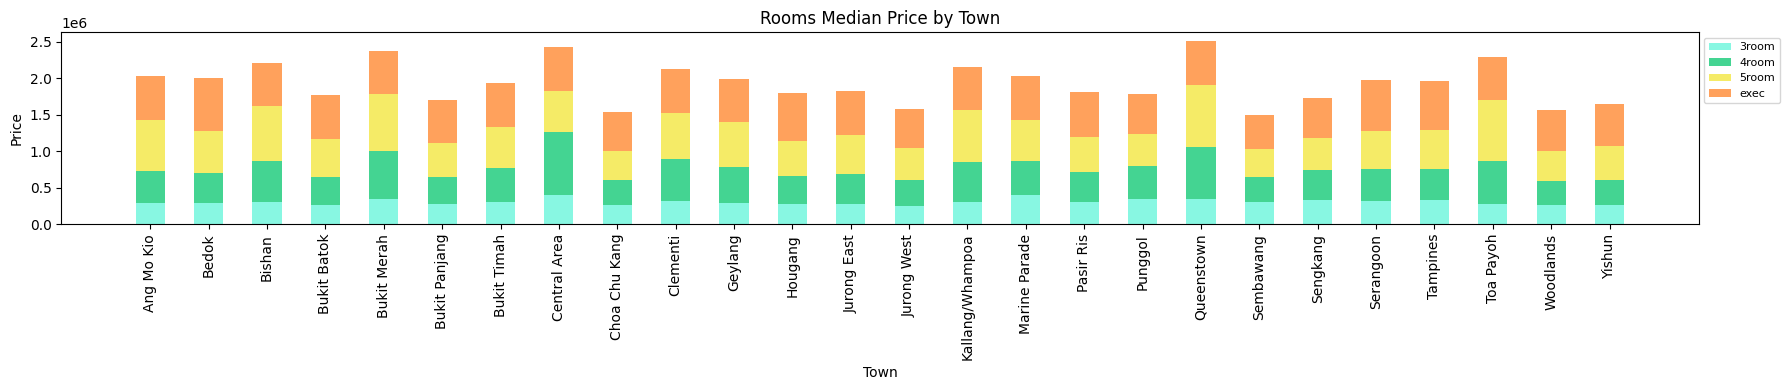

In [41]:
x = data['town']

bar_width = 0.5

fig, ax = plt.subplots(figsize=(18, 4))

room3 = data['3_room_median_price']
room4 = data['4_room_median_price']
room5 = data['5_room_median_price']
exec = data['exec_median_price']
colors = ['#88F7E2', '#44D492', '#F5EB67', '#FFA15C', '#FA233E', '#9575CD']

ax.bar(x, room3, width=bar_width, label='3room',color=colors[0])
ax.bar(x, room4, width=bar_width, bottom=room3, label='4room',color=colors[1])
ax.bar(x, room5, width=bar_width, bottom=room3+room4, label='5room',color=colors[2])
ax.bar(x, exec, width=bar_width, bottom=room3+room4+room5, label='exec',color=colors[3])

ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, rotation=90)
ax.set_xlabel('Town')
ax.set_ylabel('Price')
ax.set_title('Rooms Median Price by Town')

ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), prop={'size': 8})
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()

The table above reveals that, for different towns, the prices of 3-room and executive units are relatively similar, while the prices of 4-room and 5-room units exhibit variations across different towns. This observation potentially represents a key feature that can be utilized in our clustering analysis.Such inclusion of this feature holds the potential to enhance the effectiveness and granularity of our clustering analysis, enabling us to gain deeper insights into the underlying dynamics and relationships among the towns based on the observed price differentials.

## 5. Part 1 - Towns Clustering - Modeling and visualisation

Since this is a clustering problem, we will primarily using clustering algorithms such as K-Means and its variants to solve it.

Before that, we will normalise the data.

### Normalising the data

In [42]:
from sklearn.preprocessing import Normalizer

In [43]:
# Remove cluster column if it exists - to guard against bugs in repeated running
if 'cluster' in data.columns:
    data = data.drop(columns=['cluster'])

X = data.drop(columns=['town'])

In [44]:
# Normalize the data
scaler = Normalizer()
X_scaled = scaler.fit_transform(X)

### Standard KMeans

We will first run a standard KMeans will all the data available to us, as a baseline before tuning the model further.

In [45]:
# Do k means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

results_list = []

for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    clusters = kmeans.predict(X_scaled)
    s_score = silhouette_score(X_scaled, clusters)
    inertia = kmeans.inertia_
    results_list.append([n, s_score, inertia])

results = pd.DataFrame(results_list, columns=['n', 'silhouette_score', 'inertia'])

results

,n,silhouette_score,inertia
0,2,0.417449,0.268679
1,3,0.268796,0.222102
2,4,0.254723,0.188326
3,5,0.305781,0.112698
4,6,0.233235,0.105851
5,7,0.127115,0.097017
6,8,0.230834,0.067440
7,9,0.198938,0.059172
8,10,0.189758,0.050540


We can see that the silhouette scores range from 0.2 to 0.42. The elbow plot below indicates that n = 4 may be a sensible starting point for the number of clusters.

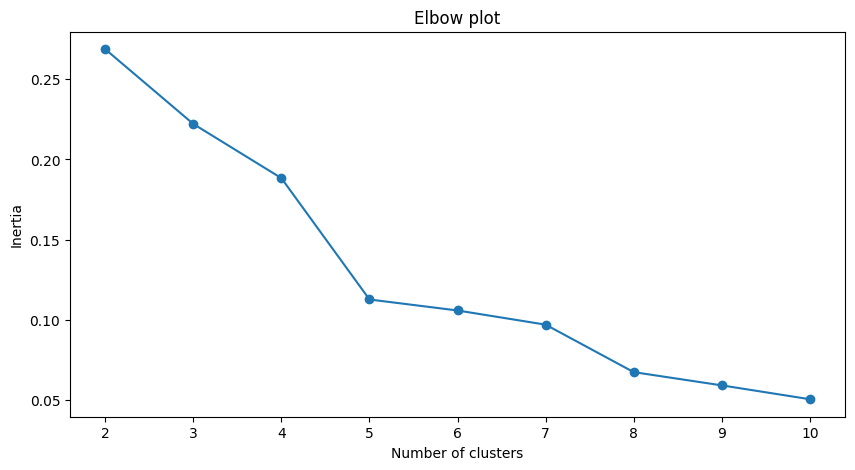

In [46]:
# plot elbow plot
plt.figure(figsize=(10, 5))
plt.plot(results['n'], results['inertia'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow plot')
plt.show()

In [53]:
final_n = 5

kmeans = KMeans(n_clusters=final_n, random_state=42, n_init='auto')
kmeans.fit(X_scaled)
y_kmeans = kmeans.predict(X_scaled)

# Add the cluster column to the data
data['cluster'] = y_kmeans

# Check the silhouette score
print('Silhouette score: ', silhouette_score(X_scaled, y_kmeans))

Silhouette score:  0.3057806479205569


Let's print the list of towns in each cluster and visualise the clusters. We will do the second part by reducing the dimensions of the dataset through Principal Component Analysis.

In [54]:
# Print list of towns in each cluster
for i in range(5):
    print('Cluster', i)
    print(data[data['cluster'] == i]['town'].values)

Cluster 0
['Central Area']
Cluster 1
['Choa Chu Kang' 'Hougang' 'Punggol' 'Sengkang' 'Tampines' 'Woodlands'
 'Yishun']
Cluster 2
['Bedok' 'Bukit Batok' 'Bukit Panjang' 'Jurong East' 'Jurong West'
 'Pasir Ris' 'Serangoon']
Cluster 3
['Bukit Timah' 'Marine Parade' 'Sembawang']
Cluster 4
['Ang Mo Kio' 'Bishan' 'Bukit Merah' 'Clementi' 'Geylang'
 'Kallang/Whampoa' 'Queenstown' 'Toa Payoh']


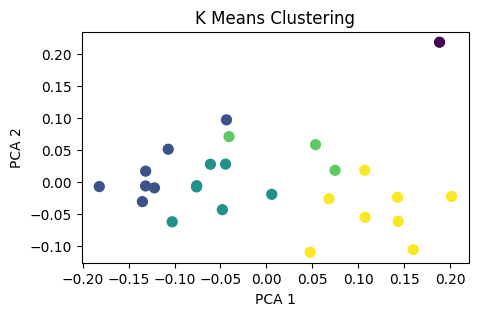

In [55]:
# Visualise the clusters using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(5, 3))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('K Means Clustering')
plt.show()

In [56]:
# Try agglomerative clustering - no improvement in silhouette scores
from sklearn.cluster import AgglomerativeClustering

results_list = []

for n in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=n)
    clusters = agg.fit_predict(X_scaled)
    s_score = silhouette_score(X_scaled, clusters)
    results_list.append([n, s_score])

results = pd.DataFrame(results_list, columns=['n', 'silhouette_score'])

results

,n,silhouette_score
0,2,0.411732
1,3,0.410684
2,4,0.296966
3,5,0.322932
4,6,0.316662
5,7,0.263083
6,8,0.225012
7,9,0.226213
8,10,0.229025


In [57]:
# Try DBSCAN - no real improvement in silhouette scores
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.1, min_samples=1)
clusters = dbscan.fit_predict(X_scaled)
s_score = silhouette_score(X_scaled, clusters)

# print no. of clusters
print('Number of clusters: ', len(np.unique(clusters)))
print('Silhouette score: ', s_score)

Number of clusters:  2
Silhouette score:  0.43445066244634406


### Tuning and improving the model

Due to the limited number of sample points (total town count) and the high number of features, in order to ensure the rationality and effectiveness of the clustering algorithm, we have decided to remove some features. After observing the features in the previous section, we have determined to retain only the following few features. These factors, namely the age distribution, dwelling indicators, and miscellaneous facilities, have a significant impact on clustering. We will continue to utilize the k-means algorithm for our analysis.

In [58]:
# Do k means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

if 'cluster' in data.columns:
    data = data.drop(columns=['cluster'])

X1 = data[['commercial','miscellaneous','total_dwelling_units', 'age_group_15_under', 'elderly_pop']]
scaler = Normalizer()
X1_scaled = scaler.fit_transform(X1)

test_results_list = []

for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=42, n_init='auto')
    kmeans.fit(X1_scaled)
    clusters = kmeans.predict(X1_scaled)
    s_score = silhouette_score(X1_scaled, clusters)
    inertia = kmeans.inertia_
    test_results_list.append([n, s_score, inertia])

test_results = pd.DataFrame(test_results_list, columns=['n', 'silhouette_score', 'inertia'])

test_results

,n,silhouette_score,inertia
0,2,0.650176,0.116368
1,3,0.528532,0.077666
2,4,0.531852,0.037498
3,5,0.560617,0.023648
4,6,0.502352,0.016479
5,7,0.516959,0.008705
6,8,0.477188,0.008419
7,9,0.459913,0.005538
8,10,0.449105,0.003485


We can see from the silhouette scores above that they are significantly better than the scores from our baseline KMeans clustering.

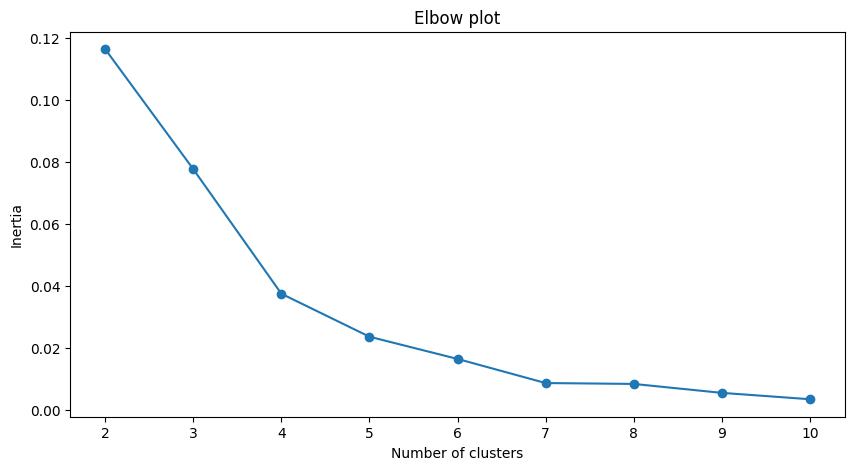

In [59]:
# plot elbow plot
plt.figure(figsize=(10, 5))
plt.plot(test_results['n'], test_results['inertia'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow plot')
plt.show()

In [60]:
test_final_n = 4

kmeans = KMeans(n_clusters=test_final_n, random_state=42, n_init='auto')
kmeans.fit(X1_scaled)
y_kmeans = kmeans.predict(X1_scaled)

# Add the cluster column to the data
data['cluster'] = y_kmeans

# Check the silhouette score
print('Silhouette score: ', silhouette_score(X1_scaled, y_kmeans))

Silhouette score:  0.531852009113062


In [61]:
for i in range(test_final_n):
    print('Cluster', i)
    print(data[data['cluster'] == i]['town'].values)

Cluster 0
['Ang Mo Kio' 'Bedok' 'Bishan' 'Bukit Panjang' 'Choa Chu Kang' 'Clementi'
 'Geylang' 'Jurong East' 'Kallang/Whampoa' 'Pasir Ris' 'Queenstown'
 'Serangoon' 'Toa Payoh']
Cluster 1
['Punggol' 'Sembawang' 'Sengkang' 'Woodlands']
Cluster 2
['Bukit Merah' 'Bukit Timah' 'Central Area' 'Marine Parade']
Cluster 3
['Bukit Batok' 'Hougang' 'Jurong West' 'Tampines' 'Yishun']


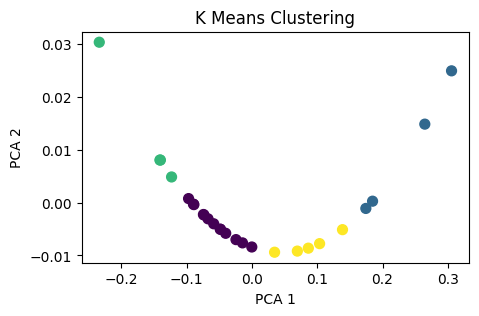

In [62]:
# Visualise the clusters using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X1_pca = pca.fit_transform(X1_scaled)

plt.figure(figsize=(5, 3))
plt.scatter(X1_pca[:, 0], X1_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('K Means Clustering')
plt.show()

In [63]:
# try agglomerative clustering - no improvement in silhouette scores
from sklearn.cluster import AgglomerativeClustering

test_results_list = []

for n in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=n)
    clusters = agg.fit_predict(X1_scaled)
    s_score = silhouette_score(X1_scaled, clusters)
    test_results_list.append([n, s_score])

test_results = pd.DataFrame(test_results_list, columns=['n', 'silhouette_score'])

test_results

,n,silhouette_score
0,2,0.650176
1,3,0.617619
2,4,0.542283
3,5,0.502231
4,6,0.530082
5,7,0.536011
6,8,0.521432
7,9,0.526088
8,10,0.503247


In [64]:
# Even though the agglo clustering silhouette scores are lower, we can visualise it using a dendrogram. Let's choose n = 4.

cluster = AgglomerativeClustering(n_clusters=4)
cluster_labels = cluster.fit_predict(X1_scaled)
data['cluster_hierarchical'] = cluster_labels

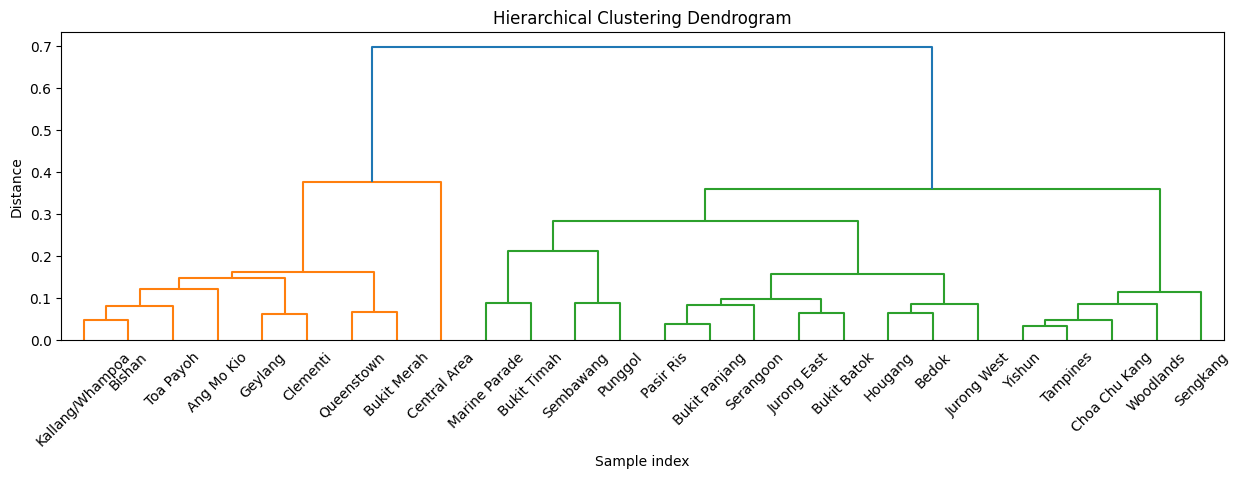

In [65]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(15, 4))
dendrogram(linked,
           orientation='top',
           labels=data['town'].values,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# 5. Insights and conclusions from Part 1

### Analysis of the dataset: Carefully selected features improved clustering
For our final chosen algorithm, the data used consisted of carefully selected features, including the number of commercial blocks, miscellaneous facilities, total dwelling units, percentage of persons 15 and under, and the elderly population. These features represent the demographics and socioeconomic characteristics of each town.

- Miscellaneous and commercial facilities represent factors related to residents' quality of life, such as facilities and services.  
- Total_dwelling_units reflects the total number of housing units, serving as an indicator of the population size of a town.  
- Age_group_15_under and Elderly_pop indicate the proportion of younger population and elderly population,reflecting the age structure of towns.

Surprisingly, the use of resale prices did not help in clustering. This may be because prices tend to be determined more by convenience (e.g. proximity to transport and amenities) rather than the specific town the flat is located in, or because we did not do an in-depth exploration of price trends / price per square meter.

### Analysis of different clustering algorithms results: KMeans was the most effective
We attempted to utilize 3 differenct clustering algorithms, K-means, DBSCAN and agglomerative clustering.  However, in this case, these algorithms did not perform as well as K-means, based on the evaluation criteria of silhouette score and inertia. Therefore, after careful consideration, we ultimately decided to proceed with the K-means algorithm for our analysis.  

### Analysis of K-means clustering results: Final silhouette score of 0.55 and inertia of 0.04

We used SSE (inertia) and the silhouette scores to select number of clusters. We plotted the SSE values against different numbers of clusters. The number of clusters corresponding to elbow point of plot was considered a reasonable choice for the optimal number of clusters, as it represents a trade-off between minimizing SSE and avoiding an overly complex or overfitting solution.

In this case,we set number of clusters to 4 (n=4). This indicates the intention to partition the dataset into four distinct clusters.     

The quality of the clustering can be evaluated using two metrics: Silhouette score and inertia.  

In this case, the silhouette score is 0.55, indicating a reasonable level of cohesion and separation in the clustering result,the inertia is 0.04, suggesting a high level of compactness in the clustering result.  

### Diving into the final clusters

Finally, let's visualise our clusters on a chloropleth map for understandability, and to see if there are any interesting location trends.

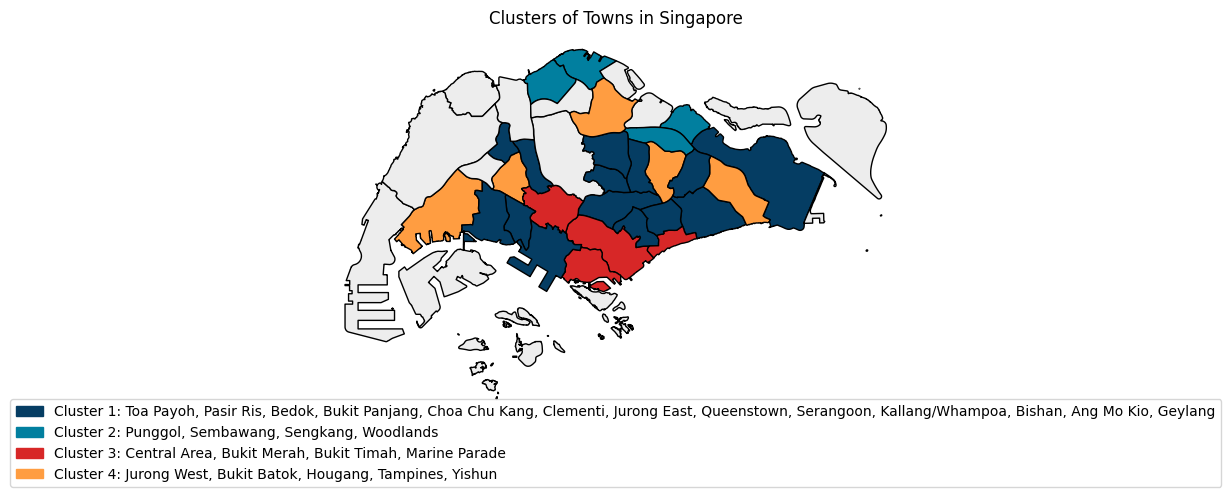

In [68]:
import geopandas

# Load the Singapore shapefile
singapore = geopandas.read_file('layer.json')
singapore['Description'] = singapore['Description'].str.title()

# add cluster column to singapore
singapore = singapore.merge(data[['town', 'cluster']], left_on='Description', right_on='town', how='left')

# for rows with no col val i.e. not in our clustering analysis, fill with 5 (to differentiate)
singapore['cluster'] = singapore['cluster'].fillna(5)

# make clusters integer
singapore['cluster'] = singapore['cluster'].astype(int)

# plot the clusters with legend
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

colours = {
    0: '#053d63',
    1: '#017f9f',
    2: '#d72727',
    3: '#ff9d41',
    4: '#663d1d',
    5: '#ededed'
}

cmap = ListedColormap([colours[i] for i in range(6)])

singapore.plot(column='cluster', figsize=(10, 5), cmap=cmap, edgecolor='black')
plt.title('Clusters of Towns in Singapore')
plt.axis('off')

cluster_towns = singapore.groupby('cluster')['Description'].unique().apply(list).to_dict()
# remove the nan cluster
cluster_towns.pop(5)
legend_patches = [Patch(color=cmap(i), label=f"Cluster {i+1}: {', '.join(towns)}")
                  for i, towns in cluster_towns.items()]

# adding the legend outside the plot at the bottom
plt.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.2))

plt.show()


The four clusters are represented above. The greyed out areas were not considered in our clustering analysis, as no HDB towns exist there (except for Tengah which we omitted as it was too new a town).

We make two observations.

**Similarity based on proximity to city center**: Even though location data was not used in the analysis, it is interesting to note that there appears to be some kind of geographical pattern in the clusters. More specifically, it seems that the similarity of towns is not based on which absolute part of the island they are in (north, south, east, west), but more dependent on their proximity to the center of Singapore.

- Cluster 1 (dark blue) consists of towns that make out the central-south of Singapore (where the main business, financial and shopping districts are).
- Cluster 3 (red) comprises two towns (Punggol and Sembawang) that are on the outskirts of town.
- Cluster 2 and 4 then fill in the rest of the blanks, even though Cluster 2 towns (light blue) are slightly further away from the city center than Cluster 3 towns (red).

This makes sense as Singapore is a small city state with its economic heart at the city center, unlike larger cities where there may more than one fully developed business and financial district.

**Similarity based on maturity of the estate**: The clusters also appear to track the HDB's classification of mature and non mature estates (link: https://www.hdb.gov.sg/-/media/doc/CCG/20082023-Annexes/Annex-A1.ashx). Clusters 1 and 4 are almost exclusively made out of mature estates (all 4 in Cluster 1, and 10 out of 13 in Cluster 3 are mature estates). Conversely, Clusters 2 and 3 are primarily non-mature estates (out of all of them, only one town in Cluster 2, Tampines, is classified mature). HDB has stated that mature estates are estates "where land for public housing development was limited yet demand was high", and "they tend to be more popular and are sold at a higher price to reflect their location attributes and higher demand". Interestingly, neither prices nor location were used in our clustering algorithm. This suggests that beyond these objective characteristics, the socioeconomic climate and demographic of these towns have also adapted a different character from non-mature towns.


# 6. Part 2 - Blocks Clustering - Data Preparation

In the second part of this project, we will look at clustering by public housing blocks instead of the towns they are in. Filtering for only residential blocks, this gives us about 10,000 data points. The idea is that users can identify blocks which are similar to those that they currently live in or are interested in.

First, we will import all the necessary libraries.

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

We load our main HDB Property dataset next


In [70]:
path = 'original_hdb_data/'

# This is one of the datasets used above, but we will import it again as it may require different processing.
properties = pd.read_csv(path + 'HDBPropertyInformation.csv')

Let's analyze the first few rows of our dataset to gauge what kind of features and data types we are dealing with.



In [71]:
properties.head()

,blk_no,street,max_floor_lvl,year_completed,residential,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,...,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental
0,1,BEACH RD,16,1970,Y,Y,N,N,N,N,...,138,1,2,0,0,0,0,0,0,0
1,1,BEDOK STH AVE 1,14,1975,Y,N,N,Y,N,N,...,204,0,2,0,0,0,0,0,0,0
2,1,CANTONMENT RD,2,2010,N,Y,N,N,N,N,...,0,0,0,0,0,0,0,0,0,0
3,1,CHAI CHEE RD,15,1982,Y,N,N,N,N,N,...,0,10,92,0,0,0,0,0,0,0
4,1,CHANGI VILLAGE RD,4,1975,Y,Y,N,N,N,N,...,54,0,1,0,0,0,0,0,0,0


Some statistics related to the columns in our main dataset

In [72]:
properties.describe()

,max_floor_lvl,year_completed,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental
count,12877.000000,12877.000000,12877.000000,12877.000000,12877.000000,12877.000000,12877.000000,12877.000000,12877.000000,12877.000000,12877.000000,12877.000000,12877.000000,12877.000000,12877.000000
mean,12.104527,1994.686728,88.208667,0.019647,3.325309,19.259067,34.951697,19.861769,5.028423,0.028500,0.649375,2.367865,2.457871,0.245166,0.013978
std,7.125137,14.721417,66.285793,2.229529,17.454455,44.429859,40.738768,29.857498,17.175975,1.212013,7.304466,23.758520,21.212183,4.075238,0.521924
min,1.000000,1937.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1984.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,1994.000000,91.000000,0.000000,0.000000,0.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16.000000,2003.000000,120.000000,0.000000,0.000000,8.000000,59.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,50.000000,2024.000000,584.000000,253.000000,234.000000,528.000000,316.000000,164.000000,135.000000,66.000000,194.000000,520.000000,452.000000,114.000000,32.000000


In [73]:
# We are only interested in residential blocks for this part due to our use case, so we will filter out residential blocks only and drop the residential column thereafter.
properties = properties[properties['residential'] == 'Y']
properties = properties.drop(columns=['residential'])

# Convert Y/N to 1/0
cols = ['commercial', 'market_hawker', 'miscellaneous', 'multistorey_carpark', 'precinct_pavilion']

for col in cols:
    properties[col] = properties[col].map({'Y': 1, 'N': 0})

# Map the town names to a more readable format. We won't use the towns for clustering as that may bias the clustering towards towns, but we will use it for visualization and also analysis of the formed clusters.

# We will map them to a more readable format, and also rename the column to 'town'

towns = {
    'AMK': 'ANG MO KIO',
    'BB': 'BUKIT BATOK',
    'BD': 'BEDOK',
    'BH': 'BISHAN',
    'BM': 'BUKIT MERAH',
    'BP': 'BUKIT PANJANG',
    'BT': 'BUKIT TIMAH',
    'CCK': 'CHOA CHU KANG',
    'CL': 'CLEMENTI',
    'CT': 'CENTRAL AREA',
    'GL': 'GEYLANG',
    'HG': 'HOUGANG',
    'JE': 'JURONG EAST',
    'JW': 'JURONG WEST',
    'KWN': 'KALLANG/WHAMPOA',
    'MP': 'MARINE PARADE',
    'PG': 'PUNGGOL',
    'PRC': 'PASIR RIS',
    'QT': 'QUEENSTOWN',
    'SB': 'SEMBAWANG',
    'SGN': 'SERANGOON',
    'SK': 'SENGKANG',
    'TAP': 'TAMPINES',
    'TG': 'TENGAH',
    'TP': 'TOA PAYOH',
    'WL': 'WOODLANDS',
    'YS': 'YISHUN'
}

properties['bldg_contract_town'] = properties['bldg_contract_town'].map(towns)

properties = properties.rename(columns={'bldg_contract_town': 'town'})

# Rearrange town to be the column after street
cols = properties.columns.tolist()
cols.insert(3, cols.pop(cols.index('town')))
properties = properties.reindex(columns=cols)

In [74]:
# Added more columns to aid us in our public house clustering, namely the age of the block and the rental to sold ratio.
# Since there is no need to use both year_completed and age_of_block, we will drop year_completed thereafter.

properties['age_of_block'] = 2023 - properties['year_completed']
properties = properties.drop(columns=['year_completed'])
properties['rental_to_sold_ratio'] = (properties[['1room_rental', '2room_rental', '3room_rental', 'other_room_rental']].sum(axis=1) + 1) / \
                                 (properties[['1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold', 'studio_apartment_sold']].sum(axis=1) + 1)

# This step has been additionally performed to identify each cluster block

properties['block_street'] = properties['blk_no'] + " " + properties['street']

In [76]:
# We will add new features to the dataset to aid in clustering, namely the latitude and longitude of each block, and their distances to nearest existing / upcoming MRT stations, primary schools and shopping malls.

# Loading new datasets (all publicly available)

path = 'additional_data/'

mrt_locations = pd.read_csv(path + "sg-mrt-existing-stations.csv")
mrt_locations.rename(columns= {"latitude": "lat", "longitude": "lng"}, inplace=True)
mrt_upcoming = pd.read_csv(path + "sg-mrt-planned-stations.csv")
mrt_upcoming.rename(columns={'latitude': 'lat', 'longitude': 'lng'}, inplace=True)
school_locations = pd.read_csv(path + "sg-primary-schools.csv")
school_locations.rename(columns={'latitude': 'lat', 'longitude': 'lng'}, inplace=True)
mall_locations = pd.read_csv(path + "sg-shopping-malls.csv")
mall_locations.rename(columns={'latitude': 'lat', 'longitude': 'lng'}, inplace=True)
zipcode_mapper = pd.read_csv(path + 'sg_zipcode_mapper_utf.csv')
zipcode_mapper.rename(columns = {"latitude": "lat", "longtitude": "lng", "street_name": "street","block":"blk_no"},inplace=True)

properties = pd.merge(properties, zipcode_mapper[['blk_no', 'street', 'lat', 'lng']], how='left',on = ['blk_no', 'street'])

In [77]:
# Let's check the number of missing values in the dataset
print("Number of missing values in the dataset: ", properties.isnull().sum().sum())

# And the number of duplicated entries
print("Number of duplicated entries in the dataset: ", properties.duplicated().sum())

# Finally, the total number of rows
print("Total number of rows in the dataset: ", len(properties))

Number of missing values in the dataset:  2250
Number of duplicated entries in the dataset:  43
Total number of rows in the dataset:  10532


In [78]:
# The number of missing values is 2250 - let's see if we can reduce that.
properties[properties.isnull().any(axis=1)]

,blk_no,street,max_floor_lvl,town,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,total_dwelling_units,...,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,age_of_block,rental_to_sold_ratio,block_street,lat,lng
13,1,JLN KUKOH,17,CENTRAL AREA,0,1,1,0,0,84,...,0,0,56,14,14,54,85.000000,1 JLN KUKOH,NaN,NaN
14,1,KG KAYU RD,10,KALLANG/WHAMPOA,0,0,0,0,0,107,...,0,0,0,0,0,60,0.009259,1 KG KAYU RD,NaN,NaN
22,1,ST. GEORGE'S RD,12,KALLANG/WHAMPOA,0,0,1,0,0,154,...,0,0,0,0,0,48,0.006452,1 ST. GEORGE'S RD,NaN,NaN
25,1,TG PAGAR PLAZA,24,CENTRAL AREA,1,0,1,0,0,163,...,0,0,0,0,0,47,0.006098,1 TG PAGAR PLAZA,NaN,NaN
29,1A,EUNOS CRES,2,GEYLANG,1,0,0,0,0,2,...,0,0,0,2,0,42,3.000000,1A EUNOS CRES,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10518,994C,BUANGKOK LINK,16,HOUGANG,0,0,0,0,0,111,...,0,0,0,0,0,4,0.008929,994C BUANGKOK LINK,NaN,NaN
10519,995A,BUANGKOK CRES,16,HOUGANG,0,0,0,0,0,120,...,0,0,0,0,0,5,0.008264,995A BUANGKOK CRES,NaN,NaN
10520,995B,BUANGKOK CRES,16,HOUGANG,0,0,0,0,0,120,...,0,0,0,0,0,5,0.008264,995B BUANGKOK CRES,NaN,NaN
10524,996C,BUANGKOK CRES,16,HOUGANG,0,0,1,0,0,104,...,0,0,0,0,0,5,0.009524,996C BUANGKOK CRES,NaN,NaN


In [79]:
# A look at the null values and the zipcode_mapper dataset show that some streets exist but the block numbers do not. In those cases, we can use the information from blocks on the same street.
# We will fill the missing values in the lat and lng columns with the mean of the lat and lng values of the blocks on the same street.

properties['lat'] = properties['lat'].fillna(properties.groupby('street')['lat'].transform('mean'))
properties['lng'] = properties['lng'].fillna(properties.groupby('street')['lng'].transform('mean'))

# Check for missing values again
print("Number of missing values in the dataset: ", properties.isnull().sum().sum())

# 774 missing values is a much better number and should not affect our analysis too much. We can proceed with the next steps.

Number of missing values in the dataset:  774


In [80]:
# Removing invalid data after incoporating new features
properties.dropna(inplace=True)
properties.drop_duplicates(inplace=True, keep='first')
properties.reset_index(inplace=True)


In [81]:
print("Total number of rows in the dataset: ", len(properties))

Total number of rows in the dataset:  10102


In [82]:
# Calculating the Haversine distance for the nearby amenities

from sklearn.neighbors import NearestNeighbors

nn_model_mrt = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='haversine')
nn_model_mrt.fit(mrt_locations[['lat', 'lng']])
properties['mrt_dist'], indices = nn_model_mrt.kneighbors(properties[['lat', 'lng']])

nn_model_school = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='haversine')
nn_model_school.fit(school_locations[['lat', 'lng']])
properties['school_dist'], indices = nn_model_school.kneighbors(properties[['lat', 'lng']])

nn_model_mall = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='haversine')
nn_model_mall.fit(mall_locations[['lat', 'lng']])
properties['mall_dist'], indices = nn_model_mall.kneighbors(properties[['lat', 'lng']])

nn_model_mrt_upcoming = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='haversine')
nn_model_mrt_upcoming.fit(mrt_upcoming[['lat', 'lng']])
properties['upcoming_mrt_dist'], indices = nn_model_mrt_upcoming.kneighbors(properties[['lat', 'lng']])

original_properties = properties.copy()

In [83]:
# Dropping the columns which may bias our results for the block clustering process
properties.drop(columns=['index','blk_no','street','town','lat','lng'],inplace=True)

In [84]:
# Check for no nan values
print(properties.isnull().sum())

max_floor_lvl            0
commercial               0
market_hawker            0
miscellaneous            0
multistorey_carpark      0
precinct_pavilion        0
total_dwelling_units     0
1room_sold               0
2room_sold               0
3room_sold               0
4room_sold               0
5room_sold               0
exec_sold                0
multigen_sold            0
studio_apartment_sold    0
1room_rental             0
2room_rental             0
3room_rental             0
other_room_rental        0
age_of_block             0
rental_to_sold_ratio     0
block_street             0
mrt_dist                 0
school_dist              0
mall_dist                0
upcoming_mrt_dist        0
dtype: int64


In [85]:
# Saving the curated dataset for submission
properties.to_csv("curated_data/part2_curated_data.csv", index=False)

# 7. Part 2 - Blocks Clustering - Exploratory data analysis and visualisation

In [86]:
# Make some observations here
properties.describe()

,max_floor_lvl,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,...,1room_rental,2room_rental,3room_rental,other_room_rental,age_of_block,rental_to_sold_ratio,mrt_dist,school_dist,mall_dist,upcoming_mrt_dist
count,10102.000000,10102.000000,10102.000000,10102.000000,10102.000000,10102.000000,10102.000000,10102.000000,10102.000000,10102.000000,...,10102.000000,10102.000000,10102.000000,10102.000000,10102.000000,10102.000000,10102.000000,10102.000000,1.010200e+04,10102.000000
mean,14.020590,0.187884,0.000099,0.261334,0.000396,0.002277,107.471590,0.025045,3.192338,23.679370,...,2.966739,3.095328,0.312215,0.017719,31.048208,5.676779,0.003291,0.001945,3.002367e-03,0.017042
std,6.118955,0.390639,0.009949,0.439383,0.019896,0.047664,56.698781,2.517195,16.647767,48.543499,...,26.604416,23.812365,4.598796,0.589133,13.736591,38.592025,0.001774,0.001327,1.925669e-03,0.010721
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.000000,0.001852,0.000147,0.000103,3.172442e-09,0.000189
25%,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,79.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,24.000000,0.008197,0.001949,0.001052,1.560318e-03,0.007188
50%,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,33.000000,0.010309,0.003038,0.001637,2.526335e-03,0.017153
75%,16.000000,0.000000,0.000000,1.000000,0.000000,0.000000,130.000000,0.000000,0.000000,24.000000,...,0.000000,0.000000,0.000000,0.000000,39.000000,0.013699,0.004364,0.002443,4.065157e-03,0.025282
max,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000,584.000000,253.000000,225.000000,528.000000,...,520.000000,452.000000,114.000000,32.000000,86.000000,521.000000,0.016882,0.014346,1.337997e-02,0.043678


Compared to comparing data by towns, there are fewer correlations here. However, there are a couple of notable correlations. For example, there is a moderate negative correlation (-0.46) between the age of the block and its maximum floor level, suggest that younger blocks tend to be built higher. There is also a moderate positive correlation between the floor level and the total dwelling units of the block, which makes sense since taller blocks can accommodate more flats. Finally, there is a strong correlation (0.82) between the rental to sold ratio and the number of 1-room rentals.

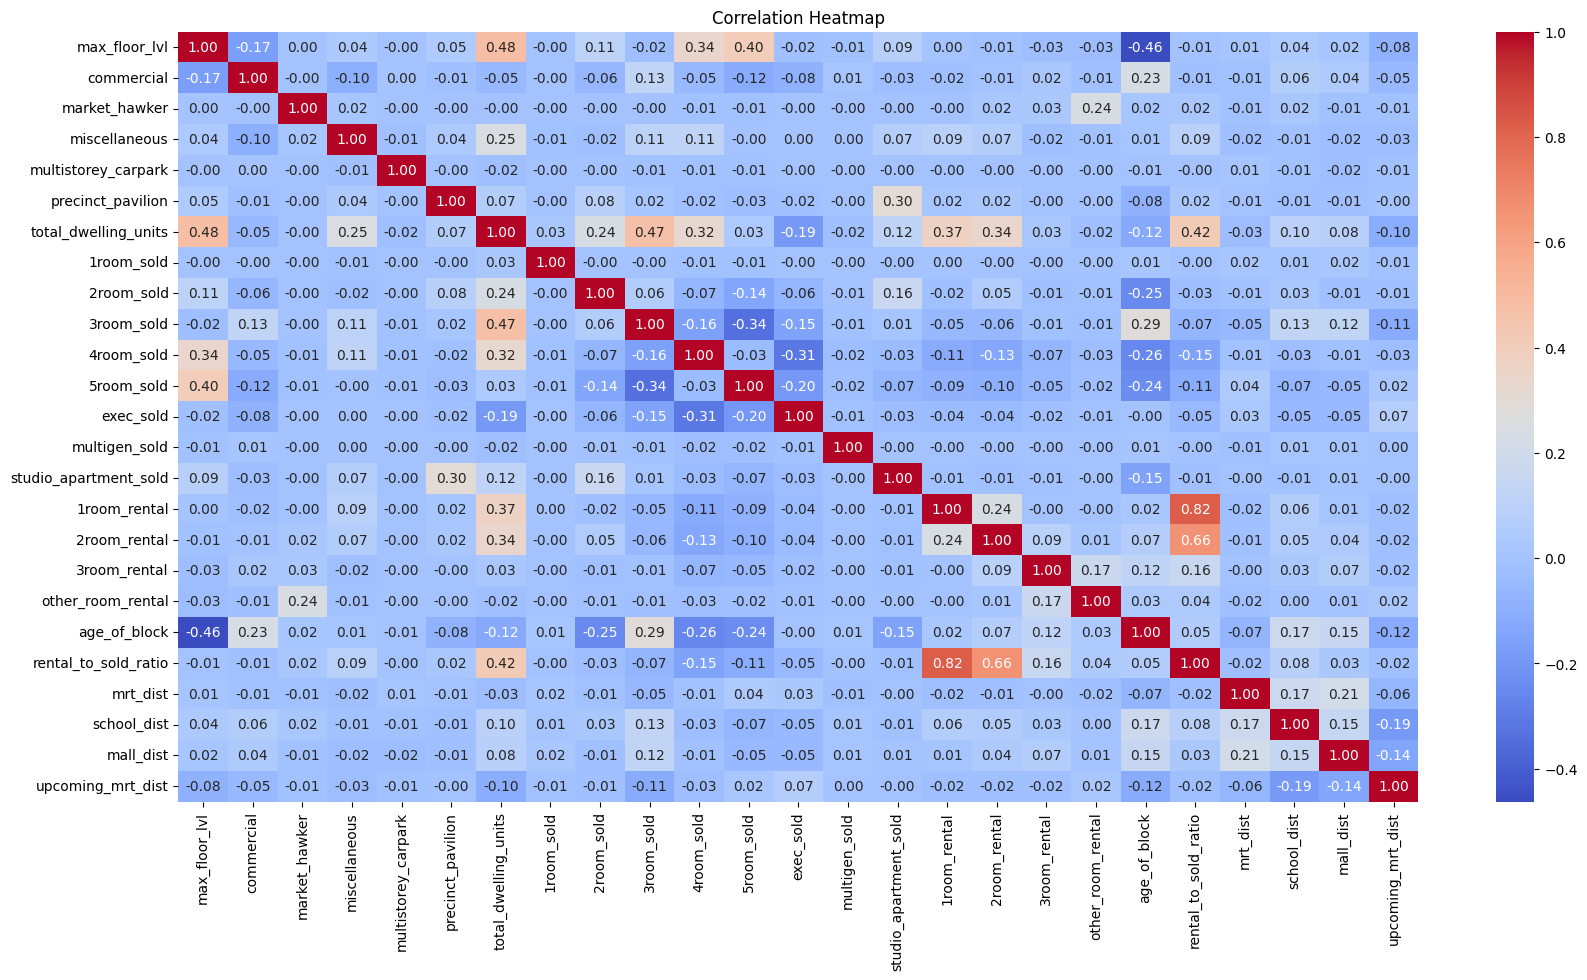

In [87]:
# Correlation heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(properties.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

The histogram below shows the distribution of the ages of the HDB blocks. As we can see, the most common age is around 40 years old, indicating that they were built in the 1980s.

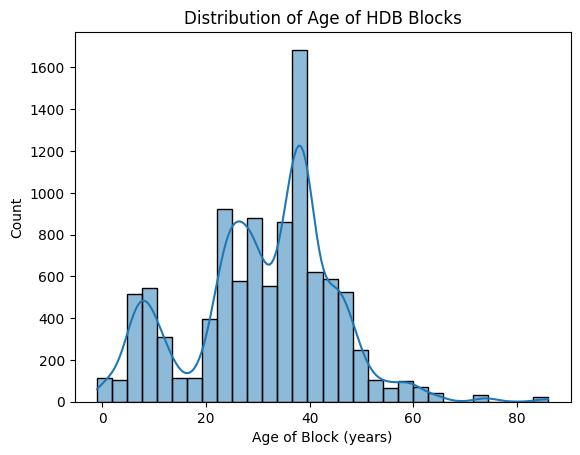

In [88]:
sns.histplot(data=properties['age_of_block'], bins=30, kde=True)
plt.title('Distribution of Age of HDB Blocks')
plt.xlabel('Age of Block (years)')
plt.ylabel('Count')
plt.show()

We can also look at the spread of maximum floor levels through a boxplot. We can see that most of the values are clustered around around 12 to 16 storeys (the interquartile range), whereas there are some rare blocks that span around storeys 25 to 50.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


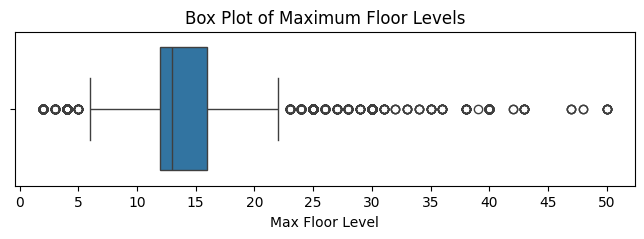

In [89]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=properties['max_floor_lvl'])
plt.title('Box Plot of Maximum Floor Levels')
plt.xlabel('Max Floor Level')
plt.xticks(np.arange(0, 51, 5))
plt.show()

## 8. Part 3 - Blocks Clustering - Modeling and visualisation

### Choosing baseline features and normalising the data

In [90]:
# Remove cluster column if it exists - to guard against bugs in repeated running
if 'cluster' in properties.columns:
    properties = properties.drop(columns=['cluster'])

X = properties.drop(columns=['block_street'])

In [91]:
# Features selected
X.columns

Index(['max_floor_lvl', 'commercial', 'market_hawker', 'miscellaneous',
       'multistorey_carpark', 'precinct_pavilion', 'total_dwelling_units',
       '1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold',
       'exec_sold', 'multigen_sold', 'studio_apartment_sold', '1room_rental',
       '2room_rental', '3room_rental', 'other_room_rental', 'age_of_block',
       'rental_to_sold_ratio', 'mrt_dist', 'school_dist', 'mall_dist',
       'upcoming_mrt_dist'],
      dtype='object')

In [92]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer()
X_scaled = scaler.fit_transform(X)

### Standard KMeans

We will first run a standard KMeans will all the features above, as a baseline before tuning the model further.

As there are around 10k data points and we are looking to recommend similar blocks to users, there should be more clusters than in Part 1. We thus run a search within the range n = (5, 15).

In [93]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

results_list = []

for n in range(5, 15):
    kmeans = KMeans(n_clusters=n, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    clusters = kmeans.predict(X_scaled)
    s_score = silhouette_score(X_scaled, clusters)
    inertia = kmeans.inertia_
    results_list.append([n, s_score, inertia])

results = pd.DataFrame(results_list, columns=['n', 'silhouette_score', 'inertia'])

results

,n,silhouette_score,inertia
0,5,0.425384,977.780838
1,6,0.475734,678.521812
2,7,0.451793,597.933127
3,8,0.483256,468.872957
4,9,0.476409,411.204282
5,10,0.450670,377.057093
6,11,0.447830,360.679036
7,12,0.449083,339.759170
8,13,0.444300,307.895045
9,14,0.440262,288.254030


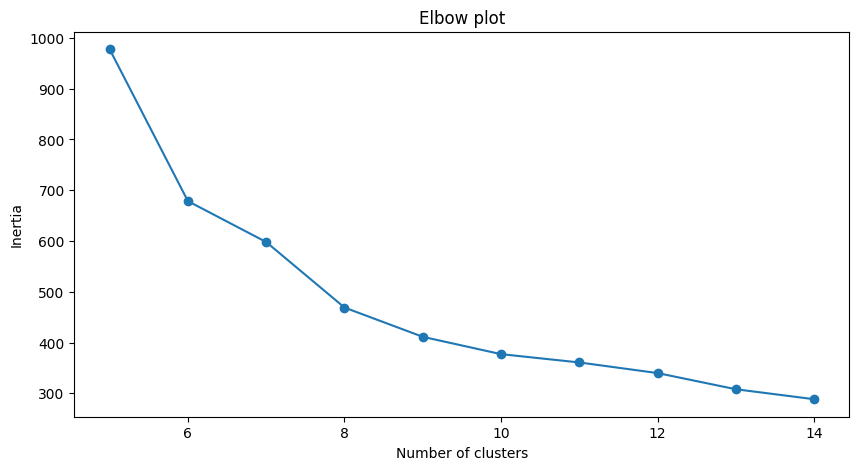

In [94]:
# plot elbow plot
plt.figure(figsize=(10, 5))
plt.plot(results['n'], results['inertia'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow plot')
plt.show()

Looking at the elbow plot, n=8 seems to be a good starting point for our clusters.

In [95]:
final_n = 8

kmeans = KMeans(n_clusters=final_n, random_state=42, n_init='auto')
kmeans.fit(X_scaled)
y_kmeans = kmeans.predict(X_scaled)

# Add the cluster column to the data
properties['cluster'] = y_kmeans

# Check the silhouette score
print('Silhouette score: ', silhouette_score(X_scaled, y_kmeans))

Silhouette score:  0.48325594652285814


Let's print the blocks in each cluster and visualise the clusters. We will do the second part by reducing the dimensions of the dataset through Principal Component Analysis.

In [96]:
# Print list of towns in each cluster
for i in range(final_n):
    print('Cluster', i)
    print(properties[properties['cluster'] == i]['block_street'].values)

Cluster 0
['10 EUNOS CRES' '10 HOLLAND AVE' '10A BENDEMEER RD' ...
 '996B BUANGKOK CRES' '996C BUANGKOK CRES' '999B BUANGKOK CRES']
Cluster 1
['10 TOH YI DR' '10B BEDOK STH AVE 2' '10D BEDOK STH AVE 2'
 '10E BEDOK STH AVE 2' '10F BEDOK STH AVE 2' '101 GANGSA RD'
 '101 PASIR RIS ST 12' '101 TECK WHYE LANE' '101A LOR 2 TOA PAYOH'
 '101B LOR 2 TOA PAYOH' '102 RIVERVALE WALK' '103 RIVERVALE WALK'
 '104 LENGKONG TIGA' '104A ANG MO KIO ST 11' '105 JLN RAJAH'
 '105 SIMEI ST 1' '106 JLN RAJAH' '106 LENGKONG TIGA' '107 GANGSA RD'
 '107 JURONG EAST ST 13' '107 TECK WHYE LANE' '108 JLN RAJAH'
 '108 LENGKONG TIGA' '108 PASIR RIS ST 12' '108 TECK WHYE LANE'
 '109 TECK WHYE LANE' '110 MCNAIR RD' '111 CLEMENTI ST 13'
 '111 EDGEFIELD PLAINS' '111 WOODLANDS ST 13' '112 EDGEFIELD PLAINS'
 '114 BEDOK RESERVOIR RD' '114 EDGEFIELD PLAINS' '115 BEDOK RESERVOIR RD'
 '115 CLEMENTI ST 13' '115 EDGEFIELD PLAINS' '115 HO CHING RD'
 '115 MARSILING RISE' '116 CLEMENTI ST 13' '116 EDGEFIELD PLAINS'
 '117 EDGEFIELD 

In [97]:
# Print the size of each cluster
properties['cluster'].value_counts()

cluster
3    2443
2    1910
0    1894
7    1504
1     891
5     790
6     416
4     254
Name: count, dtype: int64

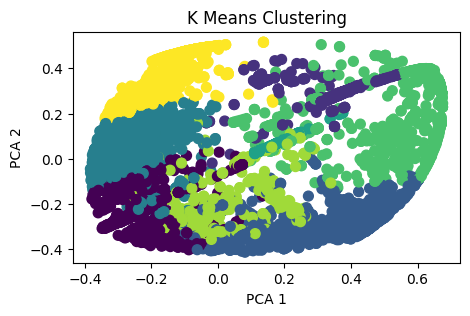

In [98]:
# Visualise the clusters using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(5, 3))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('K Means Clustering')
plt.show()

In [99]:
# Try agglomerative clustering - very slight improvement in silhouette scores
from sklearn.cluster import AgglomerativeClustering

results_list = []

for n in range(5, 15):
    agg = AgglomerativeClustering(n_clusters=n)
    clusters = agg.fit_predict(X_scaled)
    s_score = silhouette_score(X_scaled, clusters)
    results_list.append([n, s_score])

results = pd.DataFrame(results_list, columns=['n', 'silhouette_score'])

results

,n,silhouette_score
0,5,0.394765
1,6,0.424032
2,7,0.418423
3,8,0.412696
4,9,0.439252
5,10,0.429021
6,11,0.422678
7,12,0.428046
8,13,0.430262
9,14,0.432994


In [100]:
# We can visualise the clustering through a dendogram. We will choose the most promising n = 9.

cluster = AgglomerativeClustering(n_clusters=9, metric='euclidean', linkage='ward', distance_threshold=None)
cluster_labels = cluster.fit_predict(X_scaled)
properties['cluster_hierarchical'] = cluster_labels

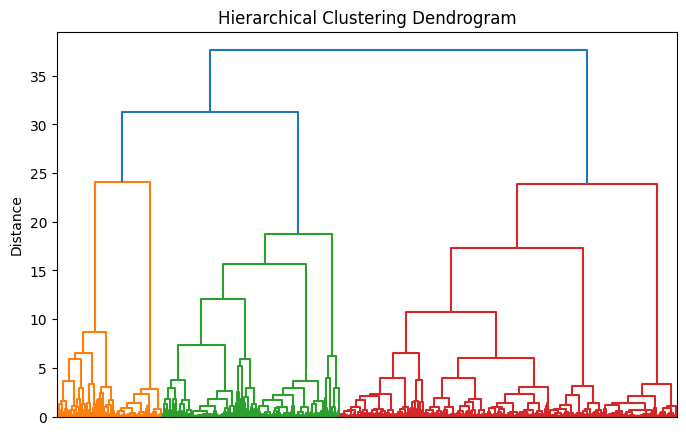

In [101]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(8, 5))
dendrogram(linked,
           orientation='top',
           labels=properties['block_street'].values,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Distance')
plt.xticks([])
plt.show()

### Tuning and improving the model: Better feature selection

The silhouette score for 10 clusters is around 0.48, which is pretty good but perhaps could be improved by better feature selection, and perhaps using DBScan. We will try both these methods.

In [102]:
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

scaler = Normalizer()
distance_features = ['mrt_dist', 'school_dist', 'mall_dist', 'upcoming_mrt_dist']
all_features_for_clustering = properties[distance_features + ['total_dwelling_units','age_of_block','rental_to_sold_ratio']]

all_features_for_clustering_scaled = scaler.fit_transform(all_features_for_clustering)

In [103]:
# Run KMeans again for the updated dataset

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

results_list = []

for n in range(5, 15):
    kmeans = KMeans(n_clusters=n, random_state=42, n_init='auto')
    kmeans.fit(all_features_for_clustering_scaled)
    clusters = kmeans.predict(all_features_for_clustering_scaled)
    cluster_sizes = dict(pd.Series(clusters).value_counts())
    cluster_sizes = sorted([v for k, v in cluster_sizes.items()])
    s_score = silhouette_score(all_features_for_clustering_scaled, clusters)
    inertia = kmeans.inertia_
    results_list.append([n, s_score, inertia])

    # print(f"Number of clusters: {n}")
    # print(f"Cluster sizes: {cluster_sizes}")
    # print()

In [104]:
results_list = pd.DataFrame(results_list, columns=['n', 'silhouette_score', 'inertia'])
results_list

,n,silhouette_score,inertia
0,5,0.575797,73.625705
1,6,0.573874,48.050609
2,7,0.565089,34.848670
3,8,0.563703,28.178209
4,9,0.557684,22.284499
5,10,0.553780,18.961058
6,11,0.551567,15.287321
7,12,0.548138,13.000496
8,13,0.550088,11.165993
9,14,0.542283,9.779279


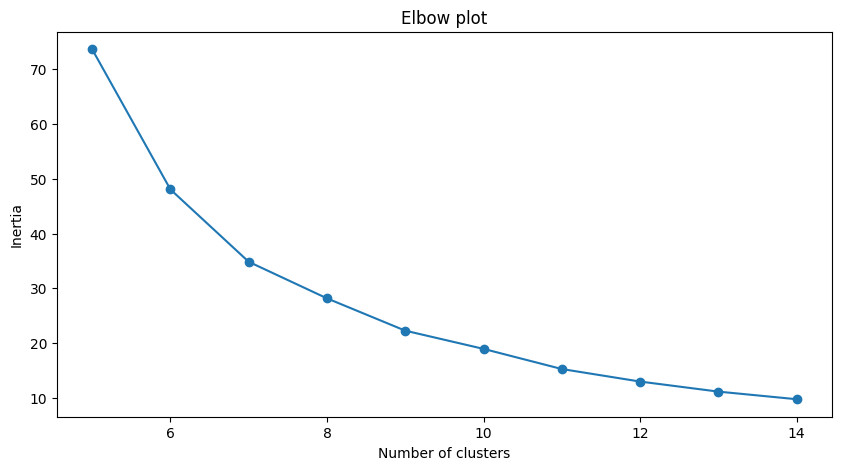

In [105]:
# elbow plot
plt.figure(figsize=(10, 5))
plt.plot(results_list['n'], results_list['inertia'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow plot')
plt.show()

### Tuning and improving the model: Trying DBScan

In [106]:
# DBScan

results_list = []

for eps in np.arange(0.1, 10.2, 1):
    for min_samples in range(20, 100, 600):
        try:
            print(f"Tuning eps = {eps}, min_samples = {min_samples}")
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            print("Tuning completed.")
            print()
            cluster_labels = dbscan.fit_predict(all_features_for_clustering_scaled)
            silhouette_avg = silhouette_score(all_features_for_clustering_scaled, cluster_labels)
            number_of_clusters = len(np.unique(cluster_labels))
            size_of_clusters = ', '.join([str(len(cluster_labels[cluster_labels == i])) for i in np.unique(cluster_labels)])
        except:
            print("Tuning failed.")
            print()

        results_list.append([eps, min_samples, silhouette_avg, number_of_clusters, size_of_clusters])

results_list = pd.DataFrame(results_list, columns=['eps', 'min_samples', 'silhouette_avg', 'number_of_clusters', 'size_of_clusters'])
results_list

Tuning eps = 0.1, min_samples = 20
Tuning completed.

Tuning eps = 1.1, min_samples = 20
Tuning completed.

Tuning failed.

Tuning eps = 2.1, min_samples = 20
Tuning completed.

Tuning failed.

Tuning eps = 3.1, min_samples = 20
Tuning completed.

Tuning failed.

Tuning eps = 4.1, min_samples = 20
Tuning completed.

Tuning failed.

Tuning eps = 5.1, min_samples = 20
Tuning completed.

Tuning failed.

Tuning eps = 6.1, min_samples = 20
Tuning completed.

Tuning failed.

Tuning eps = 7.1, min_samples = 20
Tuning completed.

Tuning failed.

Tuning eps = 8.1, min_samples = 20
Tuning completed.

Tuning failed.

Tuning eps = 9.1, min_samples = 20
Tuning completed.

Tuning failed.

Tuning eps = 10.1, min_samples = 20
Tuning completed.

Tuning failed.



,eps,min_samples,silhouette_avg,number_of_clusters,size_of_clusters
0,0.1,20,0.624946,3,"14, 9845, 243"
1,1.1,20,0.624946,3,"14, 9845, 243"
2,2.1,20,0.624946,3,"14, 9845, 243"
3,3.1,20,0.624946,3,"14, 9845, 243"
4,4.1,20,0.624946,3,"14, 9845, 243"
5,5.1,20,0.624946,3,"14, 9845, 243"
6,6.1,20,0.624946,3,"14, 9845, 243"
7,7.1,20,0.624946,3,"14, 9845, 243"
8,8.1,20,0.624946,3,"14, 9845, 243"
9,9.1,20,0.624946,3,"14, 9845, 243"


### Overall analysis of model tuning

While DBScan provided better silhouette scores on average, having experimented with different epsilons and min_samples, it appeared that it would only provide imbalanced clusters and a limited number of clusters, as seen from the table above. This is not a bad thing, but for our use case, it would be preferable to have more clusters with more balanced numbers. Since we are only looking to provide similar blocks for users to decide where to live next, it does not matter as much that some of the clusters overlap, and it makes sense since the characteristics of blocks may not be so cleanly separable.

For the reasons above, we chose to use KMeans with n = 10.

### Final model: KMeans with 10 clusters, silhouette score of 0.55

In [112]:
# Final model: Kmeans (n = 10)

final_n = 10

kmeans = KMeans(n_clusters=final_n, random_state=42, n_init='auto')
kmeans.fit(all_features_for_clustering_scaled)
y_kmeans = kmeans.predict(all_features_for_clustering_scaled)
print("Silhouette score: ", silhouette_score(all_features_for_clustering_scaled, y_kmeans))

Silhouette score:  0.5537798581391565


In [113]:
# Add the clusters to the original data
original_properties['cluster'] = y_kmeans

In [114]:
# Print the size of each cluster
original_properties['cluster'].value_counts()

cluster
0    2768
4    1950
3    1834
8    1650
5     735
1     383
7     295
6     235
2     193
9      59
Name: count, dtype: int64

PCA explained variance ratio:  [0.80678193 0.16054658]


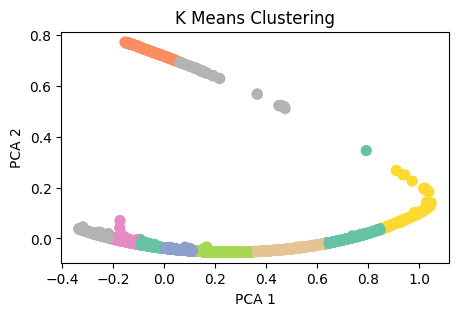

In [115]:
# Visualise the clusters using PCA
pca = PCA(n_components=2)

X_pca = pca.fit_transform(all_features_for_clustering_scaled)

print("PCA explained variance ratio: ", pca.explained_variance_ratio_)

plt.figure(figsize=(5, 3))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, s=50, cmap='Set2')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.title('K Means Clustering')
plt.show()

# 9. Insights and conclusions from Part 2

To recap, our final selected features were: distances to transport, school and amenities, the number of dwelling units in the block, the age of the block, and the rental to sold ratio of the block. We found that these were sensible choices as they would also the features that prospective homebuyers would be looking for if they wanted to find a housing block that was similar to theirs.

We also decided on 10 clusters, as that would give a sensible cluster size and reasonable options to the user. While this was not the best number of clusters as suggested by our technical analysis (i.e. the elbow plot and silhouette scores), we chose this number because the silhouette scores were still reasonable, and this ultimately fit our use case the best. This is a good example of how when using AI and analytics in practice, we must not only focus on the technical features of our model, but also the prevailing use case.

### Final evaluation and exploration of our clusters

Let's look at our finalised clusters!

From the stacked bar plot and the chloropleth map below, we can see that the blocks in each cluster area spread out across the towns. However, notably, there is a greater proportion of Central Area and Queenstown flats in Cluster 3, which may suggest some kind of location clustering.

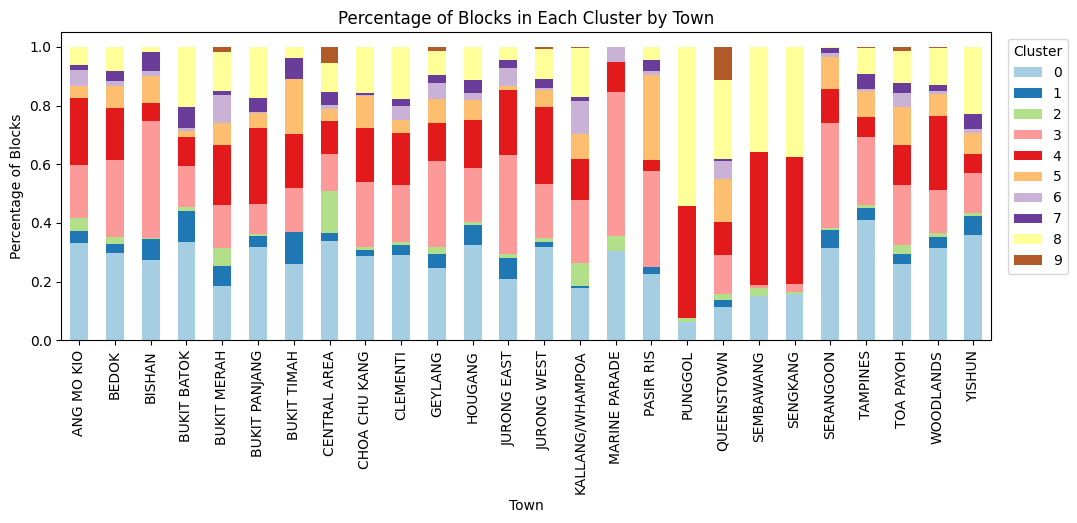

In [116]:
# Percentage of blocks in each cluster by town
clustered_properties = original_properties.groupby(['town', 'cluster']).size().unstack(fill_value=0)
clustered_properties = clustered_properties.div(clustered_properties.sum(axis=1), axis=0)
clustered_properties.plot(kind='bar', stacked=True, figsize=(12, 4), cmap='Paired')
plt.title('Percentage of Blocks in Each Cluster by Town')
plt.xlabel('Town')
plt.ylabel('Percentage of Blocks')
plt.legend(title='Cluster', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

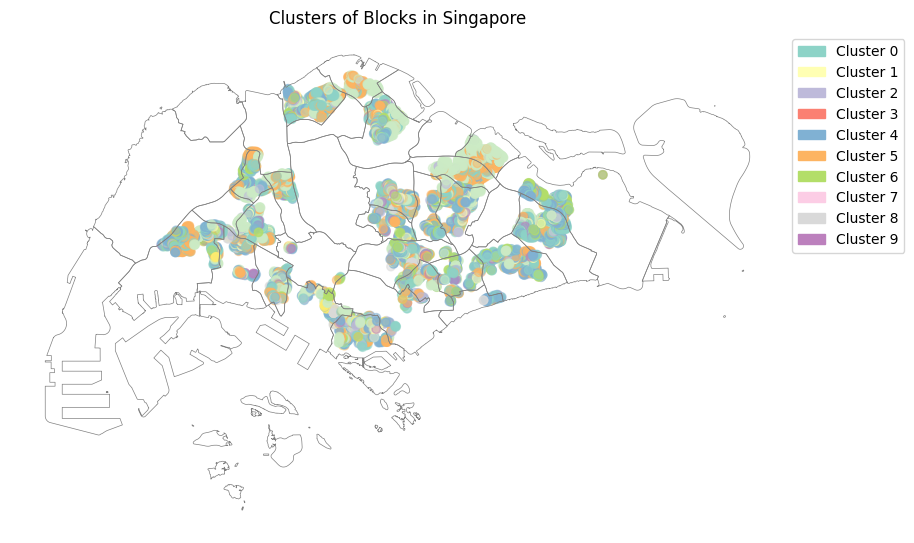

In [117]:
import geopandas as gpd
from shapely.geometry import Point

singapore = gpd.read_file('layer.json')

# DataFrame converted to GeoDataFrame
gdf = gpd.GeoDataFrame(original_properties, geometry=gpd.points_from_xy(original_properties.lng, original_properties.lat))

# Plotting the clusters on the map

fig, ax = plt.subplots(figsize=(10, 10))
singapore.boundary.plot(ax=ax, linewidth=0.5, color='grey')
plt.axis('off')
gdf.plot(column='cluster', ax=ax, cmap='Set3', alpha=0.5)
# legend
legend_patches = [Patch(color=plt.cm.Set3(i), label=f"Cluster {i}") for i in range(10)]
plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.title('Clusters of Blocks in Singapore')
plt.show()


We can also see that the average age of blocks in each cluster are quite spread out, except in Cluster 4 where the average age is very low (around 10 years in a 99 year lease).

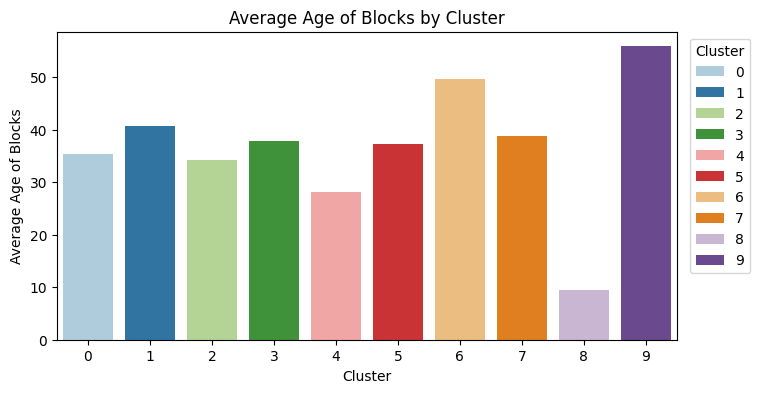

In [118]:
cluster_summary = original_properties.groupby('cluster').mean(numeric_only=True).reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(x='cluster', y='age_of_block', data=cluster_summary, palette='Paired', hue='cluster')
plt.legend(title='Cluster', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.title('Average Age of Blocks by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Age of Blocks')
plt.show()

Finally, it is interesting to see that there is quite a divergence in the average number of dwelling units in each block per cluster. In particular, Cluster 3 appears to have rather large blocks with more than 200+ total dwelling units per block. However, we can also see that towns in Cluster 3 are not the tallest (around 12.5 storeys). This suggests that blocks in this cluster are wider and more populated.

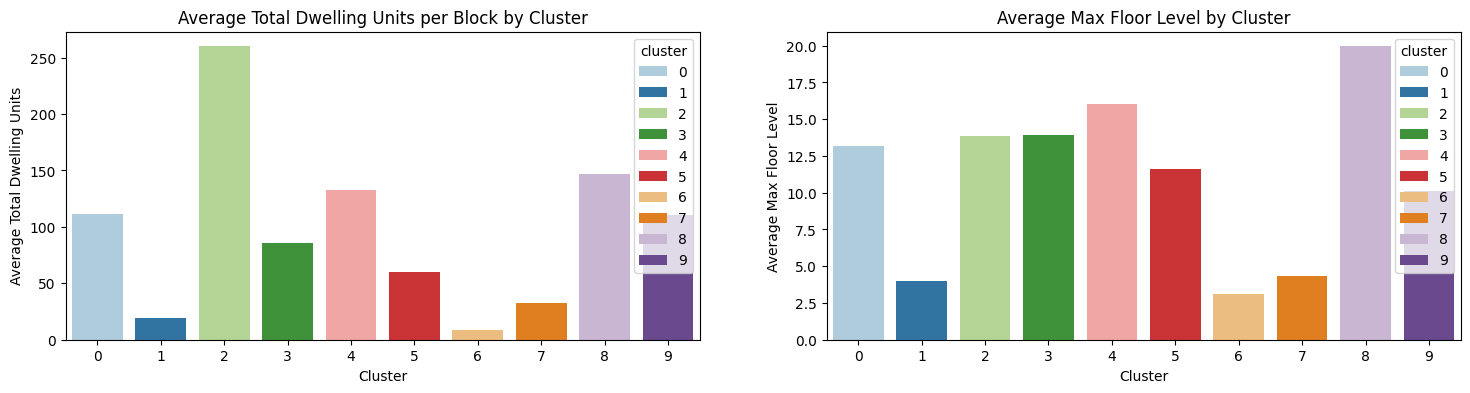

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.barplot(x='cluster', y='total_dwelling_units', data=cluster_summary, palette='Paired', hue='cluster', ax=ax[0])
ax[0].set_title('Average Total Dwelling Units per Block by Cluster')
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('Average Total Dwelling Units')

# plot average max floor level
sns.barplot(x='cluster', y='max_floor_lvl', data=cluster_summary, palette='Paired', hue='cluster', ax=ax[1])
ax[1].set_title('Average Max Floor Level by Cluster')
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('Average Max Floor Level')

plt.show()


A possible explanation for why Cluster 3 has so many dwelling units can be seen in the plots below. As can be seen, there are actually no flats for sale in Cluster 3 blocks - these are exclusively comprised of rental blocks.

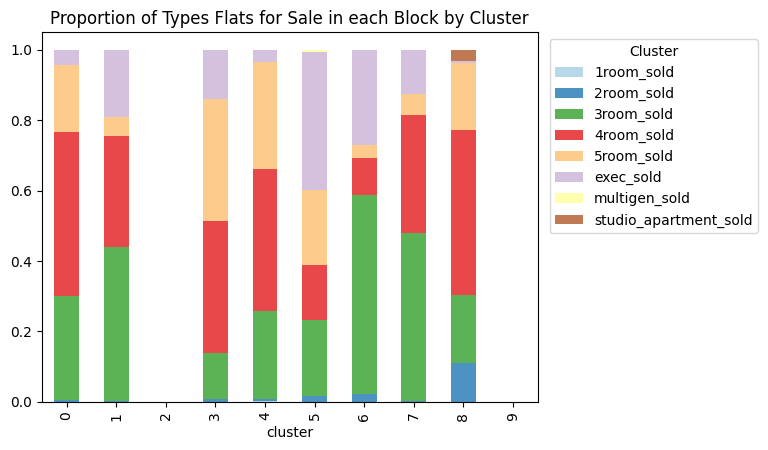

In [120]:
rooms_sold = original_properties.groupby('cluster')[['1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold', 'studio_apartment_sold']].sum()
rooms_sold = rooms_sold.div(rooms_sold.sum(axis=1), axis=0)
rooms_sold.plot(kind='bar', stacked=True, title='Proportion of Types Flats for Sale in each Block by Cluster', cmap="Paired", alpha=0.8)
plt.legend(title='Cluster', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

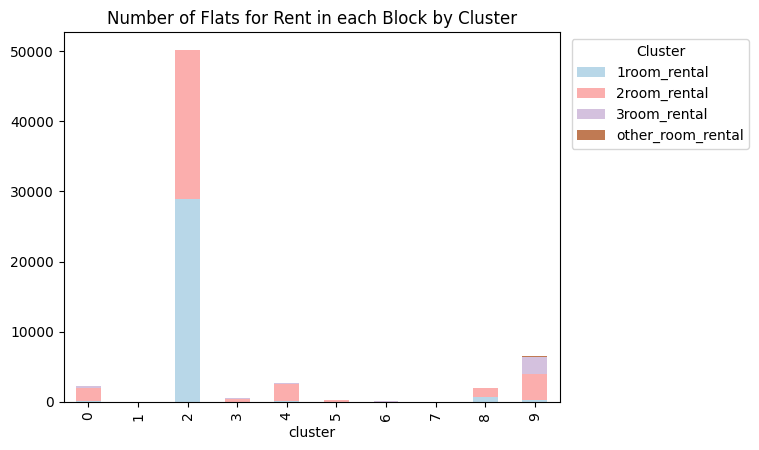

In [121]:
# number of rental flats in each cluster
rooms_rental = original_properties.groupby('cluster')[['1room_rental', '2room_rental', '3room_rental', 'other_room_rental']].sum()
rooms_rental.plot(kind='bar', stacked=True, title='Number of Flats for Rent in each Block by Cluster', cmap="Paired", alpha=0.8)
plt.legend(title='Cluster', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

We will also sample some blocks from a couple of clusters to see if there is anything interesting.

In [122]:
selected_features = ['blk_no', 'street', 'town', 'max_floor_lvl', 'age_of_block', 'rental_to_sold_ratio', 'cluster']
selected = original_properties[selected_features]

In [123]:
# sample Cluster 9 - max floor level of blocks appear to be quite low and consistent, even though it was not used in the clustering algorithm
selected[selected['cluster'] == 9].sample(10)

,blk_no,street,town,max_floor_lvl,age_of_block,rental_to_sold_ratio,cluster
4862,38,TANGLIN HALT RD,QUEENSTOWN,10,61,117.0,9
1826,18,DAKOTA CRES,GEYLANG,7,65,57.0,9
7338,6,JLN MINYAK,CENTRAL AREA,12,59,157.0,9
4586,35,TANGLIN HALT RD,QUEENSTOWN,10,61,120.0,9
9060,78,REDHILL LANE,BUKIT MERAH,10,53,145.0,9
7350,60,C'WEALTH DR,QUEENSTOWN,10,60,119.0,9
5650,441,TAMPINES ST 43,TAMPINES,4,38,41.0,9
6180,48,STIRLING RD,QUEENSTOWN,7,62,113.0,9
1416,153,WOODLANDS ST 13,WOODLANDS,4,39,33.0,9
1179,14,OLD AIRPORT RD,GEYLANG,7,65,57.0,9


In [124]:
# sample Cluster 3 - we earlier determined that these were likely to be rental blocks
selected[selected['cluster'] == 3].sample(10)

,blk_no,street,town,max_floor_lvl,age_of_block,rental_to_sold_ratio,cluster
7262,58,TELOK BLANGAH HTS,BUKIT MERAH,13,47,0.008264,3
2617,223C,COMPASSVALE WALK,SENGKANG,16,25,0.016667,3
5577,437,CHOA CHU KANG AVE 4,CHOA CHU KANG,15,31,0.014085,3
4922,392,TAMPINES AVE 7,TAMPINES,12,30,0.012500,3
879,126,GEYLANG EAST AVE 1,GEYLANG,10,40,0.010989,3
6005,466,PASIR RIS ST 41,PASIR RIS,10,31,0.015873,3
500,113,SIMEI ST 1,TAMPINES,11,36,0.012346,3
4473,34,MARINE CRES,MARINE PARADE,10,49,0.007874,3
8820,737,TAMPINES ST 72,TAMPINES,14,27,0.018868,3
3754,30,BALAM RD,GEYLANG,10,58,0.008621,3


# 10. Final conclusion

Our conclusions and insights are provided in each part of the analysis, but we make a few final observations below.

1. It is important to feature select even during KMeans, which is unsupervised learning. Although it is still possible for KMeans to produce reasonable outputs without such feature selection, being conscious of the domain and the possible important features will help it towards better and more clearly defined clusters.

2. While we tried various other clustering methods, we found that KMeans (initialising with k-means++) was still the best in terms of results and options for fine tuning.

3. Keeping the use case in mind is also important. There needs to be a balance between technical performance and usability of the model.

This was a good learning process for the team and we are glad to have gone through it.